In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import torch.nn as nn
import torch.optim as optim

In [ ]:
df = pd.read_csv('players_22.csv')
print(df.keys())

FileNotFoundError: [Errno 2] No such file or directory: 'players_22.csv'

In [ ]:
def create_unified_dataset_with_colors(dfs, years, ignore_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - ignore_columns: List of columns to ignore for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'  # Update this if the column name is different

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Drop ignored columns
        df_filtered = df.drop(columns=ignore_columns[i], errors='ignore')

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = unified_df.dropna()

    return unified_df


# Load the datasets
df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset
ignore_columns = [
    ['sofifa_id', 'nation_team_id', 'nation_jersey_number', 'release_clause_eur', 'goalkeeping_speed'],
    ['sofifa_id', 'nation_team_id', 'nation_jersey_number', 'release_clause_eur', 'goalkeeping_speed'],
    ['sofifa_id', 'nation_team_id', 'nation_jersey_number', 'release_clause_eur', 'goalkeeping_speed']
]
df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022],[2020,2021,2022],ignore_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)

#print(f'Unified dataset created with {len(unified_df)} records.')

<ipython-input-3-674c37015cff>:55: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Columns: 110 entries, sofifa_id to nation_flag_url
dtypes: float64(16), int64(44), object(50)
memory usage: 16.1+ MB
None


In [ ]:
print(df.isnull().sum())   # all that is not a num

sofifa_id_20              0
player_url_20             0
short_name_20             0
long_name                 0
player_positions_20       0
                       ... 
player_face_url_22        0
club_logo_url_22         36
club_flag_url_22         36
nation_logo_url_22     8758
nation_flag_url_22        0
Length: 328, dtype: int64


In [ ]:
# Select only numerical columns
df_numerical = df.select_dtypes(include=['number'])
print(df_numerical.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8870 entries, 0 to 10300
Columns: 165 entries, overall_2020 to goalkeeping_reflexes_2022
dtypes: float64(36), int64(129)
memory usage: 11.2 MB
None


In [ ]:
# Define feature columns and target column
target_column = 'value_eur'  #target feature name
ignore_columns = ['sofifa_id','nation_team_id','nation_jersey_number','release_clause_eur','goalkeeping_speed']  #ignore features

# Drop specified columns
df_numerical = df_numerical.drop(columns=ignore_columns)

# Drop rows with missing values
df_numerical = df_numerical.dropna()

X = df_numerical.drop(columns=[target_column])
y = df_numerical[target_column]
y = y / y.abs().max()



# Standardize numerical features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
X_scaled = X / X.abs().max()
X_scaled = X_scaled.to_numpy()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

KeyError: "['sofifa_id', 'nation_team_id', 'nation_jersey_number', 'release_clause_eur', 'goalkeeping_speed'] not found in axis"

194000000.0

In [ ]:
# Verify the DataFrame after these operations
print(df_numerical.head())
print(df_numerical.shape)

   overall  potential    value_eur  wage_eur  age  height_cm  weight_kg  \
0       93         93   78000000.0  320000.0   34        170         72   
1       92         92  119500000.0  270000.0   32        185         81   
2       91         91   45000000.0  270000.0   36        187         83   
3       91         91  129000000.0  270000.0   29        175         68   
4       91         91  125500000.0  350000.0   30        181         70   

   club_team_id  league_level  club_jersey_number  ...  mentality_penalties  \
0          73.0           1.0                30.0  ...                   75   
1          21.0           1.0                 9.0  ...                   90   
2          11.0           1.0                 7.0  ...                   88   
3          73.0           1.0                10.0  ...                   93   
4          10.0           1.0                17.0  ...                   83   

   mentality_composure  defending_marking_awareness  \
0                  

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim,2048)
        self.bn1 = nn.BatchNorm1d(2048)  # Batch Normalization after the first layer
        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # LeakyReLU with a small negative slope

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.leaky_relu(x)  # Apply LeakyReLU
        x = self.fc2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x = self.leaky_relu(x)  # Apply LeakyReLU
        x = self.fc3(x)
        x = self.bn3(x)  # Apply Batch Normalization
        x = self.leaky_relu(x)  # Apply LeakyReLU
        x = self.fc4(x)
        x = self.bn4(x)  # Apply Batch Normalization
        x = self.leaky_relu(x)  # Apply LeakyReLU
        x = self.fc5(x)
        x = nn.Sigmoid()(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]
model = SimpleNN(input_dim)

In [ ]:
# move to gpu
model.cuda()
X_train_tensor = X_train_tensor.cuda()
y_train_tensor = y_train_tensor.cuda()
X_test_tensor = X_test_tensor.cuda()
y_test_tensor = y_test_tensor.cuda()

In [ ]:
# For regression
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
torch.where(torch.isnan(X_train_tensor), torch.full_like(X_train_tensor, 0), X_train_tensor)

tensor([[0.7742, 0.7895, 0.0400,  ..., 0.3684, 0.3030, 0.3243],
        [0.7097, 0.6947, 0.0171,  ..., 0.3684, 0.4545, 0.3784],
        [0.7849, 0.8000, 0.0829,  ..., 0.2632, 0.3030, 0.2162],
        ...,
        [0.7419, 0.7263, 0.0143,  ..., 0.1842, 0.1818, 0.2973],
        [0.8280, 0.8421, 0.1771,  ..., 0.2105, 0.4242, 0.2703],
        [0.6022, 0.7158, 0.0026,  ..., 0.2368, 0.3030, 0.2973]],
       device='cuda:0')

In [ ]:
num_epochs = 500
batch_size = 64

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every few epochs
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [5/500], Loss: 0.00019068842811975628
Epoch [10/500], Loss: 4.524107134784572e-05
Epoch [15/500], Loss: 3.950053360313177e-05
Epoch [20/500], Loss: 4.165810241829604e-05
Epoch [25/500], Loss: 2.897432386816945e-05
Epoch [30/500], Loss: 2.0131361452513374e-05
Epoch [35/500], Loss: 2.1093655959703028e-05
Epoch [40/500], Loss: 1.7624061001697555e-05
Epoch [45/500], Loss: 1.6335548934875987e-05
Epoch [50/500], Loss: 1.5669393178541213e-05
Epoch [55/500], Loss: 1.4798864867771044e-05
Epoch [60/500], Loss: 1.420013632014161e-05
Epoch [65/500], Loss: 1.383153721690178e-05
Epoch [70/500], Loss: 1.3280336133902892e-05
Epoch [75/500], Loss: 1.2952491488249507e-05
Epoch [80/500], Loss: 1.2628723197849467e-05
Epoch [85/500], Loss: 1.2269686521904077e-05
Epoch [90/500], Loss: 1.1934322174056433e-05
Epoch [95/500], Loss: 1.1629624168563168e-05
Epoch [100/500], Loss: 1.1336657735228073e-05
Epoch [105/500], Loss: 1.104690363717964e-05
Epoch [110/500], Loss: 1.0765596925921272e-05
Epoch [115/500]

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_loss = criterion(test_outputs, y_test_tensor)
    test_l1 = torch.nn.functional.l1_loss(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    print(f'Mean distance: {test_l1.item() * df_numerical[target_column].abs().max()}')

Test Loss: 0.0001
Mean distance: 500575.93639940023


In [ ]:
xx = torch.nn.functional.l1_loss(test_outputs, y_test_tensor, reduction='none')

In [ ]:
xx * df_numerical[target_column].abs().max()

tensor([294466.8750, 175454.2188, 333591.8750,  ...,  45857.2500,
        117467.1484, 245945.0938], device='cuda:0')

In [ ]:
(xx * df_numerical[target_column].abs().max()).cpu() / (y_test * df_numerical[target_column].abs().max()).to_numpy()

tensor([0.6199, 0.1350, 3.3359,  ..., 0.0496, 0.0839, 0.5787],
       dtype=torch.float64)

In [ ]:
gt = ((y_test * df_numerical[target_column].abs().max()).to_numpy())[:50]
output = (test_outputs * df_numerical[target_column].abs().max())[:50]

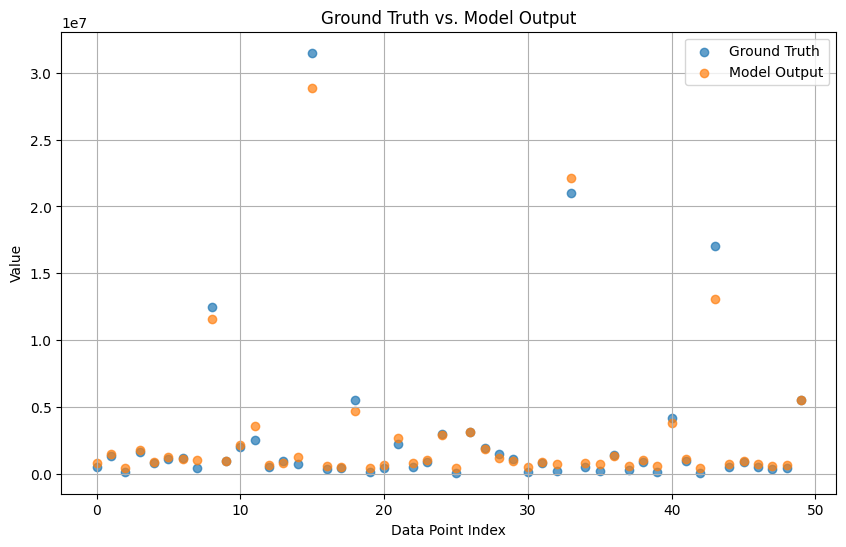

In [ ]:
# prompt: i want to visuallize gt and output on the same plot as scatter

import matplotlib.pyplot as plt

# Assuming 'gt' and 'output' are already defined as in the preceding code

plt.figure(figsize=(10, 6))
plt.scatter(range(len(gt)), gt, label='Ground Truth', alpha=0.7)
plt.scatter(range(len(output)), output.cpu().numpy(), label='Model Output', alpha=0.7)
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.title('Ground Truth vs. Model Output')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
np.where(X_train == X_train.max())

(array([    2,   120,   191,   268,   276,   276,   296,   316,   387,
          414,   418,   428,   481,   507,   519,   644,   714,   720,
          726,   781,   822,   841,   870,   892,   897,   900,   989,
         1007,  1046,  1077,  1083,  1089,  1116,  1122,  1149,  1239,
         1258,  1262,  1277,  1331,  1353,  1367,  1373,  1385,  1452,
         1473,  1517,  1558,  1578,  1589,  1594,  1607,  1616,  1626,
         1629,  1678,  1737,  1817,  1824,  1876,  1878,  1909,  1915,
         1927,  1928,  1975,  2010,  2059,  2085,  2120,  2122,  2128,
         2133,  2199,  2204,  2260,  2261,  2270,  2270,  2270,  2277,
         2281,  2281,  2282,  2284,  2318,  2319,  2336,  2340,  2346,
         2413,  2420,  2426,  2435,  2441,  2574,  2605,  2665,  2668,
         2707,  2736,  2751,  2757,  2814,  2877,  2940,  2954,  2963,
         2975,  3015,  3058,  3068,  3076,  3090,  3093,  3093,  3093,
         3136,  3162,  3162,  3204,  3210,  3240,  3252,  3260,  3272,
      

In [ ]:
X_train.shape,

((13632, 54),)

In [ ]:
X.abs().max()

,0
overall,93.0
potential,95.0
wage_eur,350000.0
age,39.0
height_cm,203.0
weight_kg,110.0
club_team_id,115820.0
league_level,5.0
club_jersey_number,99.0
club_contract_valid_until,2031.0


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [2]:
!pip install pytorch-tabnet


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
#optuna together with evaluate - take a lot ot rime to run so ignoreeeee!!!!!!!!!

import optuna
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('unified_players-6.csv')


def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    accuracy = np.mean(np.where(np.abs((y_true - y_pred) / y_true) > 0.05, 0, 1))
    return accuracy

def objective(trial, model_name, X_train, X_test, y_train, y_test):
    if model_name == 'TabNet':
        # Define hyperparameters for TabNet
        n_d = trial.suggest_int('n_d', 8, 64)
        n_a = trial.suggest_int('n_a', 8, 64)
        n_steps = trial.suggest_int('n_steps', 3, 10)
        gamma = trial.suggest_float('gamma', 1.0, 2.0)
        lambda_sparse = trial.suggest_float('lambda_sparse', 1e-6, 1e-3)

        model = TabNetRegressor(n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse)
        model.fit(X_train, y_train.values.reshape(-1, 1), max_epochs=100, patience=10, batch_size=1024)

    elif model_name == 'MLP':
        # Define hyperparameters for MLP
        hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50, 50), (100, 100), (150, 150)])
        alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
        learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-1)

        model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, learning_rate_init=learning_rate_init, max_iter=500, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        # Define hyperparameters for XGBoost
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)

        model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, random_state=42)
        model.fit(X_train, y_train)

    # Predict and calculate the custom accuracy
    y_pred = model.predict(X_test)
    accuracy = custom_accuracy(y_test, y_pred)

    # We want to maximize accuracy, so return the negative of accuracy to minimize the objective
    return -accuracy

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Hyperparameter optimization for each model
    best_params = {}
    for model_name in ['TabNet', 'MLP', 'XGBoost']:
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, model_name, X_train_scaled, X_test_scaled, y_train, y_test), n_trials=50)
        best_params[model_name] = study.best_params
        print(f"Best hyperparameters for {model_name}: {study.best_params}")

    # Train and evaluate the models with the best hyperparameters
    for model_name in ['TabNet', 'MLP', 'XGBoost']:
        if model_name == 'TabNet':
            model = TabNetRegressor(**best_params[model_name])
            model.fit(X_train_scaled, y_train.values.reshape(-1, 1), max_epochs=100, patience=10, batch_size=1024)

        elif model_name == 'MLP':
            model = MLPRegressor(**best_params[model_name], max_iter=500, random_state=42)
            model.fit(X_train_scaled, y_train)

        elif model_name == 'XGBoost':
            model = XGBRegressor(**best_params[model_name], random_state=42)
            model.fit(X_train_scaled, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        accuracy = custom_accuracy(y_test, y_pred)
        print(f"{model_name} - Mean Absolute Error: {mae}")
        print(f"{model_name} - R-squared: {r2}")
        print(f"{model_name} - Custom Accuracy: {accuracy}")

        # Plot the predicted vs. actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, alpha=0.3)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model_name} - Predictions vs Actual Values')
        plt.show()


ModuleNotFoundError: No module named 'optuna'

In [ ]:
fifa_pred('value_eur_2022')
fifa_pred('potential_2022')

[I 2024-08-13 08:15:22,322] A new study created in memory with name: no-name-7f66f2f3-1d92-4dde-b8a7-a5fb70440350
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 134452258100565.31|  0:00:00s
epoch 1  | loss: 134636329325909.31|  0:00:01s
epoch 2  | loss: 134705132688725.31|  0:00:01s
epoch 3  | loss: 131381911530154.69|  0:00:02s
epoch 4  | loss: 132888318181376.0|  0:00:03s
epoch 5  | loss: 123005910209877.31|  0:00:03s
epoch 6  | loss: 132985015063893.31|  0:00:04s
epoch 7  | loss: 133050461585408.0|  0:00:05s
epoch 8  | loss: 134104922193920.0|  0:00:06s
epoch 9  | loss: 133314130913962.69|  0:00:07s
epoch 10 | loss: 134614058969770.69|  0:00:07s
epoch 11 | loss: 133097128809813.31|  0:00:08s
epoch 12 | loss: 132729109392042.69|  0:00:09s
epoch 13 | loss: 133899234923861.31|  0:00:09s
epoch 14 | loss: 133211852810922.69|  0:00:10s
epoch 15 | loss: 129957839066453.31|  0:00:11s
epoch 16 | loss: 134802531418112.0|  0:00:11s
epoch 17 | loss: 123150904502954.69|  0:00:12s
epoch 18 | loss: 129910044972373.31|  0:00:12s
epoch 19 | loss: 124442133572266.69|  0:00:13s
epoch 20 | loss: 134291950403584.0|  0:00:14s
epoch 21 | loss: 1

[I 2024-08-13 08:16:30,578] Trial 0 finished with value: -0.0 and parameters: {'n_d': 27, 'n_a': 21, 'n_steps': 10, 'gamma': 1.9666530718874076, 'lambda_sparse': 0.0007871980383175916}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 124684948821333.31|  0:00:00s
epoch 1  | loss: 132505873154048.0|  0:00:01s
epoch 2  | loss: 132159085303125.31|  0:00:02s
epoch 3  | loss: 129694909333504.0|  0:00:02s
epoch 4  | loss: 130904350872917.31|  0:00:03s
epoch 5  | loss: 130898504013141.31|  0:00:04s
epoch 6  | loss: 132543645657770.69|  0:00:04s
epoch 7  | loss: 132318921839957.31|  0:00:05s
epoch 8  | loss: 130616657969152.0|  0:00:05s
epoch 9  | loss: 131961706949290.69|  0:00:06s
epoch 10 | loss: 124176628536661.31|  0:00:06s
epoch 11 | loss: 123781520905557.31|  0:00:07s
epoch 12 | loss: 125126470620501.31|  0:00:08s
epoch 13 | loss: 128472651399168.0|  0:00:08s
epoch 14 | loss: 130246644858880.0|  0:00:09s
epoch 15 | loss: 130600748974080.0|  0:00:09s
epoch 16 | loss: 129092287113898.69|  0:00:10s
epoch 17 | loss: 132707763180885.31|  0:00:11s
epoch 18 | loss: 127471241745749.31|  0:00:11s
epoch 19 | loss: 130398294114304.0|  0:00:12s
epoch 20 | loss: 129341295951872.0|  0:00:13s
epoch 21 | loss: 1291

[I 2024-08-13 08:17:33,604] Trial 1 finished with value: -0.0 and parameters: {'n_d': 64, 'n_a': 57, 'n_steps': 9, 'gamma': 1.5422015582950288, 'lambda_sparse': 0.0009917949327379872}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 133131671699456.0|  0:00:00s
epoch 1  | loss: 136052372493653.31|  0:00:01s
epoch 2  | loss: 133939097589077.31|  0:00:01s
epoch 3  | loss: 134813264642048.0|  0:00:02s
epoch 4  | loss: 132372583765333.31|  0:00:02s
epoch 5  | loss: 133420246805162.69|  0:00:02s
epoch 6  | loss: 133544111592789.31|  0:00:03s
epoch 7  | loss: 133604975138133.31|  0:00:03s
epoch 8  | loss: 134458036453376.0|  0:00:03s
epoch 9  | loss: 134093280204117.31|  0:00:04s
epoch 10 | loss: 127019580915712.0|  0:00:04s
epoch 11 | loss: 123076015205034.69|  0:00:04s
epoch 12 | loss: 131235619799040.0|  0:00:05s
epoch 13 | loss: 124703893094400.0|  0:00:05s
epoch 14 | loss: 130846469477717.31|  0:00:06s
epoch 15 | loss: 128471402894677.31|  0:00:06s
epoch 16 | loss: 122958507584170.69|  0:00:06s
epoch 17 | loss: 126493106285226.69|  0:00:07s
epoch 18 | loss: 134467979750058.69|  0:00:07s
epoch 19 | loss: 133115978011989.31|  0:00:07s
epoch 20 | loss: 133938794201088.0|  0:00:08s
epoch 21 | loss: 134

[I 2024-08-13 08:18:14,173] Trial 2 finished with value: -0.0 and parameters: {'n_d': 27, 'n_a': 63, 'n_steps': 5, 'gamma': 1.5233443252508205, 'lambda_sparse': 0.000903227088429723}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 129541232831146.69|  0:00:00s
epoch 1  | loss: 129987471824213.31|  0:00:01s
epoch 2  | loss: 134103895987541.31|  0:00:01s
epoch 3  | loss: 130552785709738.69|  0:00:02s
epoch 4  | loss: 123476484554752.0|  0:00:03s
epoch 5  | loss: 128452419474773.31|  0:00:03s
epoch 6  | loss: 128373723146922.69|  0:00:04s
epoch 7  | loss: 134194903995733.31|  0:00:05s
epoch 8  | loss: 133938834746026.69|  0:00:05s
epoch 9  | loss: 129492190232576.0|  0:00:06s
epoch 10 | loss: 131404936861013.31|  0:00:06s
epoch 11 | loss: 134304259287722.69|  0:00:07s
epoch 12 | loss: 134024246154581.31|  0:00:08s
epoch 13 | loss: 131123019513856.0|  0:00:08s
epoch 14 | loss: 134291244362410.69|  0:00:09s
epoch 15 | loss: 133554714793301.31|  0:00:10s
epoch 16 | loss: 127065715463509.31|  0:00:11s
epoch 17 | loss: 134217308569600.0|  0:00:12s
epoch 18 | loss: 121201889727829.31|  0:00:12s
epoch 19 | loss: 127405405153962.69|  0:00:13s
epoch 20 | loss: 134057416108714.69|  0:00:14s
epoch 21 | loss: 

[I 2024-08-13 08:19:22,276] Trial 3 finished with value: -0.0 and parameters: {'n_d': 44, 'n_a': 33, 'n_steps': 10, 'gamma': 1.3995942538198904, 'lambda_sparse': 0.0008295972265837331}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 132681550178986.69|  0:00:00s
epoch 1  | loss: 133294879058602.69|  0:00:01s
epoch 2  | loss: 129562479777109.31|  0:00:01s
epoch 3  | loss: 132521731817472.0|  0:00:02s
epoch 4  | loss: 133864040518997.31|  0:00:02s
epoch 5  | loss: 129661873597098.69|  0:00:03s
epoch 6  | loss: 132889428273834.69|  0:00:03s
epoch 7  | loss: 132105454135978.69|  0:00:04s
epoch 8  | loss: 130696665716053.31|  0:00:05s
epoch 9  | loss: 132499324447402.69|  0:00:06s
epoch 10 | loss: 132810692799146.69|  0:00:06s
epoch 11 | loss: 132477125394432.0|  0:00:07s
epoch 12 | loss: 128927024545792.0|  0:00:07s
epoch 13 | loss: 134883723356842.69|  0:00:08s
epoch 14 | loss: 132312854080170.69|  0:00:08s
epoch 15 | loss: 131674532741120.0|  0:00:09s
epoch 16 | loss: 131196126232576.0|  0:00:09s
epoch 17 | loss: 131155055607808.0|  0:00:10s
epoch 18 | loss: 128908385058816.0|  0:00:10s
epoch 19 | loss: 133582429356032.0|  0:00:11s
epoch 20 | loss: 132340488951125.31|  0:00:11s
epoch 21 | loss: 1312

[I 2024-08-13 08:20:19,624] Trial 4 finished with value: -0.0 and parameters: {'n_d': 23, 'n_a': 37, 'n_steps': 8, 'gamma': 1.2568233865499163, 'lambda_sparse': 0.0008355708025568223}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 135833905179306.69|  0:00:00s
epoch 1  | loss: 132655962128384.0|  0:00:00s
epoch 2  | loss: 133512882203306.69|  0:00:00s
epoch 3  | loss: 128119156856149.31|  0:00:01s
epoch 4  | loss: 133319510807893.31|  0:00:01s
epoch 5  | loss: 132587379665578.69|  0:00:01s
epoch 6  | loss: 130830075341482.69|  0:00:01s
epoch 7  | loss: 131598144678570.69|  0:00:02s
epoch 8  | loss: 134734120921770.69|  0:00:02s
epoch 9  | loss: 130345388561749.31|  0:00:02s
epoch 10 | loss: 133113128681472.0|  0:00:02s
epoch 11 | loss: 133703065927680.0|  0:00:03s
epoch 12 | loss: 132517046779904.0|  0:00:03s
epoch 13 | loss: 125566285337941.31|  0:00:03s
epoch 14 | loss: 130251083830613.31|  0:00:03s
epoch 15 | loss: 130129679701333.31|  0:00:04s
epoch 16 | loss: 132228631057749.31|  0:00:04s
epoch 17 | loss: 132209086999210.69|  0:00:04s
epoch 18 | loss: 131174944997376.0|  0:00:04s
epoch 19 | loss: 130039312023552.0|  0:00:05s
epoch 20 | loss: 132833080595797.31|  0:00:05s
epoch 21 | loss: 13

[I 2024-08-13 08:20:47,954] Trial 5 finished with value: -0.0 and parameters: {'n_d': 9, 'n_a': 47, 'n_steps': 3, 'gamma': 1.4509063859502211, 'lambda_sparse': 3.586607113223506e-05}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 133093025382400.0|  0:00:00s
epoch 1  | loss: 129022879771306.69|  0:00:01s
epoch 2  | loss: 133247080770218.69|  0:00:01s
epoch 3  | loss: 132251812975957.31|  0:00:02s
epoch 4  | loss: 133088660510037.31|  0:00:03s
epoch 5  | loss: 130031194647210.69|  0:00:03s
epoch 6  | loss: 134061800554496.0|  0:00:04s
epoch 7  | loss: 133778774512981.31|  0:00:04s
epoch 8  | loss: 130908855555413.31|  0:00:05s
epoch 9  | loss: 132495408365568.0|  0:00:06s
epoch 10 | loss: 134179010379776.0|  0:00:07s
epoch 11 | loss: 130781045325824.0|  0:00:08s
epoch 12 | loss: 131611236499456.0|  0:00:08s
epoch 13 | loss: 131476554601813.31|  0:00:09s
epoch 14 | loss: 135378775659861.31|  0:00:10s
epoch 15 | loss: 135554865124693.31|  0:00:10s
epoch 16 | loss: 130108706783232.0|  0:00:11s
epoch 17 | loss: 134459536616106.69|  0:00:12s
epoch 18 | loss: 132875464037717.31|  0:00:12s
epoch 19 | loss: 132476780063402.69|  0:00:13s
epoch 20 | loss: 129552972688042.69|  0:00:14s
epoch 21 | loss: 132

[I 2024-08-13 08:21:55,886] Trial 6 finished with value: -0.0 and parameters: {'n_d': 11, 'n_a': 40, 'n_steps': 10, 'gamma': 1.666268062035357, 'lambda_sparse': 0.0009095533689803867}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 130678136679082.69|  0:00:00s
epoch 1  | loss: 132844858201429.31|  0:00:01s
epoch 2  | loss: 131355642604202.69|  0:00:01s
epoch 3  | loss: 128475949520213.31|  0:00:02s
epoch 4  | loss: 133533298677077.31|  0:00:02s
epoch 5  | loss: 134583520242346.69|  0:00:03s
epoch 6  | loss: 133024287730346.69|  0:00:03s
epoch 7  | loss: 125179054609749.31|  0:00:04s
epoch 8  | loss: 134551457584469.31|  0:00:04s
epoch 9  | loss: 129076907999232.0|  0:00:05s
epoch 10 | loss: 132719958818816.0|  0:00:05s
epoch 11 | loss: 130364626436096.0|  0:00:06s
epoch 12 | loss: 125532659602773.31|  0:00:06s
epoch 13 | loss: 133605295303338.69|  0:00:07s
epoch 14 | loss: 127316849415509.31|  0:00:07s
epoch 15 | loss: 129084812864170.69|  0:00:08s
epoch 16 | loss: 134525238990165.31|  0:00:08s
epoch 17 | loss: 131178897429845.31|  0:00:09s
epoch 18 | loss: 124285544824832.0|  0:00:09s
epoch 19 | loss: 128942044348416.0|  0:00:10s
epoch 20 | loss: 132605546594304.0|  0:00:10s
epoch 21 | loss: 13

[I 2024-08-13 08:22:47,315] Trial 7 finished with value: -0.0 and parameters: {'n_d': 12, 'n_a': 60, 'n_steps': 7, 'gamma': 1.0211880378165272, 'lambda_sparse': 0.0007524743572435685}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 130603659821056.0|  0:00:00s
epoch 1  | loss: 128282024476672.0|  0:00:00s
epoch 2  | loss: 129305054369109.31|  0:00:01s
epoch 3  | loss: 131666046266026.69|  0:00:01s
epoch 4  | loss: 125625204124330.69|  0:00:02s
epoch 5  | loss: 129386876851541.31|  0:00:02s
epoch 6  | loss: 134010400757077.31|  0:00:02s
epoch 7  | loss: 133838980950698.69|  0:00:03s
epoch 8  | loss: 125505536436906.69|  0:00:03s
epoch 9  | loss: 128333396312064.0|  0:00:04s
epoch 10 | loss: 131982556834474.69|  0:00:04s
epoch 11 | loss: 134139072217088.0|  0:00:05s
epoch 12 | loss: 133238629247658.69|  0:00:05s
epoch 13 | loss: 122731075644074.69|  0:00:05s
epoch 14 | loss: 133472924467200.0|  0:00:06s
epoch 15 | loss: 135132178546688.0|  0:00:06s
epoch 16 | loss: 128575663505408.0|  0:00:07s
epoch 17 | loss: 134096884509354.69|  0:00:07s
epoch 18 | loss: 128589274021888.0|  0:00:08s
epoch 19 | loss: 127672870327637.31|  0:00:08s
epoch 20 | loss: 130619967275008.0|  0:00:08s
epoch 21 | loss: 12890

[I 2024-08-13 08:23:32,529] Trial 8 finished with value: -0.0 and parameters: {'n_d': 9, 'n_a': 43, 'n_steps': 6, 'gamma': 1.434429900244061, 'lambda_sparse': 0.0006236436755672467}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 132083034182997.31|  0:00:00s
epoch 1  | loss: 128770796508501.31|  0:00:00s
epoch 2  | loss: 134220880718506.69|  0:00:00s
epoch 3  | loss: 129746608324608.0|  0:00:01s
epoch 4  | loss: 131697230916266.69|  0:00:01s
epoch 5  | loss: 129146782307669.31|  0:00:01s
epoch 6  | loss: 132658801672192.0|  0:00:02s
epoch 7  | loss: 123266105256618.69|  0:00:02s
epoch 8  | loss: 131706113054037.31|  0:00:02s
epoch 9  | loss: 130557270818816.0|  0:00:03s
epoch 10 | loss: 131276863788373.31|  0:00:03s
epoch 11 | loss: 123951613913770.69|  0:00:03s
epoch 12 | loss: 127628022033066.69|  0:00:04s
epoch 13 | loss: 133008580061866.69|  0:00:04s
epoch 14 | loss: 133550568024746.69|  0:00:04s
epoch 15 | loss: 134557075155626.69|  0:00:04s
epoch 16 | loss: 132234387040938.69|  0:00:05s
epoch 17 | loss: 128763779437909.31|  0:00:05s
epoch 18 | loss: 134520695160832.0|  0:00:05s
epoch 19 | loss: 133667347234816.0|  0:00:05s
epoch 20 | loss: 133743889088512.0|  0:00:06s
epoch 21 | loss: 13

[I 2024-08-13 08:24:01,410] Trial 9 finished with value: -0.0 and parameters: {'n_d': 58, 'n_a': 47, 'n_steps': 3, 'gamma': 1.6001062372135784, 'lambda_sparse': 0.0004693907948604996}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 133288651915264.0|  0:00:00s
epoch 1  | loss: 132825374261248.0|  0:00:01s
epoch 2  | loss: 131986574977706.69|  0:00:01s
epoch 3  | loss: 133870867447808.0|  0:00:02s
epoch 4  | loss: 129895746590037.31|  0:00:02s
epoch 5  | loss: 135041882172074.69|  0:00:03s
epoch 6  | loss: 132523766054912.0|  0:00:03s
epoch 7  | loss: 133445611159552.0|  0:00:04s
epoch 8  | loss: 132505743130624.0|  0:00:04s
epoch 9  | loss: 134179938719061.31|  0:00:05s
epoch 10 | loss: 131451009892352.0|  0:00:05s
epoch 11 | loss: 131355442675712.0|  0:00:06s
epoch 12 | loss: 126821602776405.31|  0:00:07s
epoch 13 | loss: 134787174673066.69|  0:00:07s
epoch 14 | loss: 132048000559786.69|  0:00:08s
epoch 15 | loss: 133287276183552.0|  0:00:08s
epoch 16 | loss: 130155249576618.69|  0:00:09s
epoch 17 | loss: 134864291146410.69|  0:00:10s
epoch 18 | loss: 125506976481280.0|  0:00:10s
epoch 19 | loss: 124966508254549.31|  0:00:11s
epoch 20 | loss: 131994967780010.69|  0:00:12s
epoch 21 | loss: 132421

[I 2024-08-13 08:25:01,009] Trial 10 finished with value: -0.0 and parameters: {'n_d': 44, 'n_a': 13, 'n_steps': 8, 'gamma': 1.9576682859096683, 'lambda_sparse': 0.00037464166339181066}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 132431740228949.31|  0:00:01s
epoch 1  | loss: 133414630632106.69|  0:00:02s
epoch 2  | loss: 131449018996053.31|  0:00:03s
epoch 3  | loss: 129097025279317.31|  0:00:03s
epoch 4  | loss: 127099873875285.31|  0:00:04s
epoch 5  | loss: 131248009773056.0|  0:00:05s
epoch 6  | loss: 132384582270976.0|  0:00:05s
epoch 7  | loss: 131180815624874.69|  0:00:06s
epoch 8  | loss: 124314057703424.0|  0:00:07s
epoch 9  | loss: 135175577010176.0|  0:00:07s
epoch 10 | loss: 131030426058752.0|  0:00:08s
epoch 11 | loss: 129648100900864.0|  0:00:09s
epoch 12 | loss: 129754255938901.31|  0:00:09s
epoch 13 | loss: 132687952084992.0|  0:00:10s
epoch 14 | loss: 128295381936810.69|  0:00:11s
epoch 15 | loss: 134180236514645.31|  0:00:11s
epoch 16 | loss: 129853768597504.0|  0:00:12s
epoch 17 | loss: 133271342022656.0|  0:00:13s
epoch 18 | loss: 128757875255978.69|  0:00:14s
epoch 19 | loss: 131394969796608.0|  0:00:15s
epoch 20 | loss: 131595061865130.69|  0:00:16s
epoch 21 | loss: 124890

[I 2024-08-13 08:26:10,976] Trial 11 finished with value: -0.0 and parameters: {'n_d': 62, 'n_a': 20, 'n_steps': 9, 'gamma': 1.9811249005852176, 'lambda_sparse': 0.0009728647755982575}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 129892600862037.31|  0:00:00s
epoch 1  | loss: 131891882972501.31|  0:00:01s
epoch 2  | loss: 128789935117653.31|  0:00:02s
epoch 3  | loss: 131387670309546.69|  0:00:02s
epoch 4  | loss: 130733683245056.0|  0:00:03s
epoch 5  | loss: 131826987302912.0|  0:00:04s
epoch 6  | loss: 133563946456405.31|  0:00:05s
epoch 7  | loss: 130483947394389.31|  0:00:05s
epoch 8  | loss: 133819151679488.0|  0:00:06s
epoch 9  | loss: 129393236814506.69|  0:00:07s
epoch 10 | loss: 128126143168512.0|  0:00:08s
epoch 11 | loss: 130419356510890.69|  0:00:09s
epoch 12 | loss: 133831912150357.31|  0:00:10s
epoch 13 | loss: 133395641619797.31|  0:00:10s
epoch 14 | loss: 132359809313450.69|  0:00:11s
epoch 15 | loss: 133294248514901.31|  0:00:12s
epoch 16 | loss: 133879723021653.31|  0:00:13s
epoch 17 | loss: 129595535086933.31|  0:00:13s
epoch 18 | loss: 127724913251669.31|  0:00:14s
epoch 19 | loss: 131037940853418.69|  0:00:15s
epoch 20 | loss: 133673736557909.31|  0:00:15s
epoch 21 | loss: 

[I 2024-08-13 08:27:29,122] Trial 12 finished with value: -0.0 and parameters: {'n_d': 34, 'n_a': 24, 'n_steps': 10, 'gamma': 1.796728544081044, 'lambda_sparse': 0.0006634754724470397}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 129903447332181.31|  0:00:00s
epoch 1  | loss: 135555080432298.69|  0:00:01s
epoch 2  | loss: 129038902012586.69|  0:00:01s
epoch 3  | loss: 135538936556202.69|  0:00:02s
epoch 4  | loss: 122980803106133.31|  0:00:02s
epoch 5  | loss: 134467701527893.31|  0:00:03s
epoch 6  | loss: 129783165878272.0|  0:00:04s
epoch 7  | loss: 130042105430016.0|  0:00:05s
epoch 8  | loss: 130323145468586.69|  0:00:06s
epoch 9  | loss: 131394069419349.31|  0:00:06s
epoch 10 | loss: 133104183629141.31|  0:00:07s
epoch 11 | loss: 128869666040490.69|  0:00:07s
epoch 12 | loss: 131534115831808.0|  0:00:08s
epoch 13 | loss: 130269523389098.69|  0:00:09s
epoch 14 | loss: 134065857844565.31|  0:00:09s
epoch 15 | loss: 133414780228949.31|  0:00:10s
epoch 16 | loss: 129550562361344.0|  0:00:10s
epoch 17 | loss: 135198279379626.69|  0:00:11s
epoch 18 | loss: 126695570931712.0|  0:00:12s
epoch 19 | loss: 134462748054869.31|  0:00:12s
epoch 20 | loss: 132851131482112.0|  0:00:13s
epoch 21 | loss: 12

[I 2024-08-13 08:28:32,572] Trial 13 finished with value: -0.0 and parameters: {'n_d': 55, 'n_a': 10, 'n_steps': 8, 'gamma': 1.7923609995714453, 'lambda_sparse': 0.0009820448152813284}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 130585010547370.69|  0:00:00s
epoch 1  | loss: 133230335710549.31|  0:00:01s
epoch 2  | loss: 131404412573013.31|  0:00:02s
epoch 3  | loss: 132262646863189.31|  0:00:02s
epoch 4  | loss: 134426081449301.31|  0:00:03s
epoch 5  | loss: 131161710570154.69|  0:00:04s
epoch 6  | loss: 131599559557120.0|  0:00:05s
epoch 7  | loss: 132572700999680.0|  0:00:06s
epoch 8  | loss: 136024971105621.31|  0:00:06s
epoch 9  | loss: 133846126646613.31|  0:00:07s
epoch 10 | loss: 131270214418432.0|  0:00:07s
epoch 11 | loss: 129996899221504.0|  0:00:08s
epoch 12 | loss: 131855947573930.69|  0:00:09s
epoch 13 | loss: 131358466768896.0|  0:00:09s
epoch 14 | loss: 132803319212714.69|  0:00:10s
epoch 15 | loss: 135662211345066.69|  0:00:10s
epoch 16 | loss: 128268879527936.0|  0:00:11s
epoch 17 | loss: 132339016750421.31|  0:00:12s
epoch 18 | loss: 132804868308992.0|  0:00:12s
epoch 19 | loss: 132495924264960.0|  0:00:13s
epoch 20 | loss: 129535831965696.0|  0:00:13s
epoch 21 | loss: 13409

[I 2024-08-13 08:29:39,672] Trial 14 finished with value: -0.0 and parameters: {'n_d': 47, 'n_a': 55, 'n_steps': 9, 'gamma': 1.2011049684700534, 'lambda_sparse': 0.00027185332090902273}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 129099927737685.31|  0:00:00s
epoch 1  | loss: 125864177390933.31|  0:00:01s
epoch 2  | loss: 119364994291029.31|  0:00:02s
epoch 3  | loss: 131836497188181.31|  0:00:02s
epoch 4  | loss: 124657992029525.31|  0:00:03s
epoch 5  | loss: 134846403837952.0|  0:00:03s
epoch 6  | loss: 127025964646400.0|  0:00:04s
epoch 7  | loss: 128573865547093.31|  0:00:05s
epoch 8  | loss: 131202346385408.0|  0:00:05s
epoch 9  | loss: 131453999033002.69|  0:00:06s
epoch 10 | loss: 120094604656640.0|  0:00:06s
epoch 11 | loss: 128985304399872.0|  0:00:07s
epoch 12 | loss: 128081328428373.31|  0:00:08s
epoch 13 | loss: 133547362178389.31|  0:00:08s
epoch 14 | loss: 130654921206442.69|  0:00:09s
epoch 15 | loss: 131868833873920.0|  0:00:09s
epoch 16 | loss: 131294549770240.0|  0:00:10s
epoch 17 | loss: 132368290196138.69|  0:00:11s
epoch 18 | loss: 131533412586837.31|  0:00:11s
epoch 19 | loss: 124709479907328.0|  0:00:12s
epoch 20 | loss: 131355741869397.31|  0:00:13s
epoch 21 | loss: 1328

[I 2024-08-13 08:30:46,474] Trial 15 finished with value: -0.0 and parameters: {'n_d': 25, 'n_a': 30, 'n_steps': 9, 'gamma': 1.7965255355573215, 'lambda_sparse': 0.0006720071700844262}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 131721513140224.0|  0:00:00s
epoch 1  | loss: 131319947679061.31|  0:00:00s
epoch 2  | loss: 132443699587754.69|  0:00:01s
epoch 3  | loss: 132068489734826.69|  0:00:01s
epoch 4  | loss: 128512325320704.0|  0:00:02s
epoch 5  | loss: 130455047241728.0|  0:00:02s
epoch 6  | loss: 130320157026986.69|  0:00:03s
epoch 7  | loss: 130061407617024.0|  0:00:03s
epoch 8  | loss: 131039452200960.0|  0:00:03s
epoch 9  | loss: 134187881332736.0|  0:00:04s
epoch 10 | loss: 134993951064064.0|  0:00:04s
epoch 11 | loss: 130865163490645.31|  0:00:05s
epoch 12 | loss: 131180502450176.0|  0:00:05s
epoch 13 | loss: 128929474019328.0|  0:00:06s
epoch 14 | loss: 128689418622293.31|  0:00:06s
epoch 15 | loss: 127284983889920.0|  0:00:07s
epoch 16 | loss: 132020592181248.0|  0:00:07s
epoch 17 | loss: 129859546950314.69|  0:00:08s
epoch 18 | loss: 133805258746538.69|  0:00:09s
epoch 19 | loss: 133051016631637.31|  0:00:09s
epoch 20 | loss: 128250076463104.0|  0:00:10s
epoch 21 | loss: 12729046

[I 2024-08-13 08:31:33,845] Trial 16 finished with value: -0.0 and parameters: {'n_d': 36, 'n_a': 21, 'n_steps': 6, 'gamma': 1.2651278522020628, 'lambda_sparse': 0.0005689077238924069}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 135901659966122.69|  0:00:00s
epoch 1  | loss: 134698557418154.69|  0:00:00s
epoch 2  | loss: 130737680416768.0|  0:00:01s
epoch 3  | loss: 127809534732970.69|  0:00:01s
epoch 4  | loss: 129466828674389.31|  0:00:02s
epoch 5  | loss: 131324694233088.0|  0:00:02s
epoch 6  | loss: 129935872098304.0|  0:00:03s
epoch 7  | loss: 128840647049216.0|  0:00:03s
epoch 8  | loss: 131157356882602.69|  0:00:04s
epoch 9  | loss: 132488033381034.69|  0:00:04s
epoch 10 | loss: 133283204912469.31|  0:00:05s
epoch 11 | loss: 128892891299840.0|  0:00:05s
epoch 12 | loss: 134732267039402.69|  0:00:06s
epoch 13 | loss: 131336657786197.31|  0:00:06s
epoch 14 | loss: 134026593566720.0|  0:00:07s
epoch 15 | loss: 131347469303808.0|  0:00:07s
epoch 16 | loss: 130351292743680.0|  0:00:08s
epoch 17 | loss: 133132925796352.0|  0:00:08s
epoch 18 | loss: 129045391998976.0|  0:00:09s
epoch 19 | loss: 128306516415829.31|  0:00:10s
epoch 20 | loss: 126778235770197.31|  0:00:10s
epoch 21 | loss: 133527

[I 2024-08-13 08:32:26,515] Trial 17 finished with value: -0.0 and parameters: {'n_d': 18, 'n_a': 57, 'n_steps': 7, 'gamma': 1.6942613365428556, 'lambda_sparse': 0.0007726454552390968}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 130865643039402.69|  0:00:00s
epoch 1  | loss: 130526684555946.69|  0:00:01s
epoch 2  | loss: 130614433589930.69|  0:00:01s
epoch 3  | loss: 133388723814400.0|  0:00:02s
epoch 4  | loss: 128474338907477.31|  0:00:03s
epoch 5  | loss: 131295156546218.69|  0:00:03s
epoch 6  | loss: 131041417931434.69|  0:00:04s
epoch 7  | loss: 130605053728085.31|  0:00:04s
epoch 8  | loss: 132525885576533.31|  0:00:05s
epoch 9  | loss: 132451734476117.31|  0:00:06s
epoch 10 | loss: 129631009112064.0|  0:00:06s
epoch 11 | loss: 124557618140501.31|  0:00:07s
epoch 12 | loss: 131250104128853.31|  0:00:08s
epoch 13 | loss: 123298370639189.31|  0:00:09s
epoch 14 | loss: 131402969732437.31|  0:00:09s
epoch 15 | loss: 127275155237546.69|  0:00:10s
epoch 16 | loss: 130820930360661.31|  0:00:10s
epoch 17 | loss: 131724341499221.31|  0:00:11s
epoch 18 | loss: 135510237730133.31|  0:00:12s
epoch 19 | loss: 128057578881024.0|  0:00:12s
epoch 20 | loss: 129383343849472.0|  0:00:13s
epoch 21 | loss: 

[I 2024-08-13 08:33:34,545] Trial 18 finished with value: -0.0 and parameters: {'n_d': 51, 'n_a': 28, 'n_steps': 9, 'gamma': 1.863010894335478, 'lambda_sparse': 0.0004721207711791611}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 132088467204778.69|  0:00:00s
epoch 1  | loss: 126073738799786.69|  0:00:00s
epoch 2  | loss: 131724313537194.69|  0:00:01s
epoch 3  | loss: 130878650974208.0|  0:00:02s
epoch 4  | loss: 122395637579776.0|  0:00:02s
epoch 5  | loss: 133334104189610.69|  0:00:03s
epoch 6  | loss: 130742825429674.69|  0:00:03s
epoch 7  | loss: 131331679147349.31|  0:00:04s
epoch 8  | loss: 123250161309013.31|  0:00:04s
epoch 9  | loss: 133093625167872.0|  0:00:04s
epoch 10 | loss: 133950701830144.0|  0:00:05s
epoch 11 | loss: 126279129672362.69|  0:00:05s
epoch 12 | loss: 132668919731541.31|  0:00:06s
epoch 13 | loss: 123707864733013.31|  0:00:06s
epoch 14 | loss: 131515913950549.31|  0:00:07s
epoch 15 | loss: 130248631560874.69|  0:00:07s
epoch 16 | loss: 132617739436032.0|  0:00:07s
epoch 17 | loss: 133559538242901.31|  0:00:08s
epoch 18 | loss: 130543699449173.31|  0:00:08s
epoch 19 | loss: 129409306591232.0|  0:00:09s
epoch 20 | loss: 129103536237226.69|  0:00:09s
epoch 21 | loss: 12

[I 2024-08-13 08:34:17,723] Trial 19 finished with value: -0.0 and parameters: {'n_d': 30, 'n_a': 15, 'n_steps': 5, 'gamma': 1.123170869841559, 'lambda_sparse': 0.0009977766287344709}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 132944088443562.69|  0:00:00s
epoch 1  | loss: 133207974477824.0|  0:00:01s
epoch 2  | loss: 129032167358464.0|  0:00:01s
epoch 3  | loss: 132225706229760.0|  0:00:02s
epoch 4  | loss: 129066096481621.31|  0:00:03s
epoch 5  | loss: 131306370717013.31|  0:00:03s
epoch 6  | loss: 128578115775146.69|  0:00:04s
epoch 7  | loss: 130871464733354.69|  0:00:05s
epoch 8  | loss: 131981810248362.69|  0:00:05s
epoch 9  | loss: 125065054825130.69|  0:00:06s
epoch 10 | loss: 126966018255530.69|  0:00:07s
epoch 11 | loss: 134070077314389.31|  0:00:07s
epoch 12 | loss: 130672349937664.0|  0:00:08s
epoch 13 | loss: 135041809470805.31|  0:00:09s
epoch 14 | loss: 130435025032533.31|  0:00:10s
epoch 15 | loss: 132512533708800.0|  0:00:11s
epoch 16 | loss: 131819102011392.0|  0:00:11s
epoch 17 | loss: 133560940538538.69|  0:00:12s
epoch 18 | loss: 130133353911637.31|  0:00:13s
epoch 19 | loss: 131275187464874.69|  0:00:14s
epoch 20 | loss: 124844322586624.0|  0:00:14s
epoch 21 | loss: 132

[I 2024-08-13 08:35:28,765] Trial 20 finished with value: -0.0 and parameters: {'n_d': 40, 'n_a': 54, 'n_steps': 10, 'gamma': 1.5597405097631845, 'lambda_sparse': 0.0002080372956649455}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 131353400049664.0|  0:00:00s
epoch 1  | loss: 134915123314688.0|  0:00:00s
epoch 2  | loss: 134496344429909.31|  0:00:01s
epoch 3  | loss: 133161862299648.0|  0:00:01s
epoch 4  | loss: 135242464974165.31|  0:00:02s
epoch 5  | loss: 129614951918250.69|  0:00:02s
epoch 6  | loss: 133313615014570.69|  0:00:02s
epoch 7  | loss: 131096852649301.31|  0:00:03s
epoch 8  | loss: 133177985204224.0|  0:00:03s
epoch 9  | loss: 131229483532288.0|  0:00:03s
epoch 10 | loss: 127979264234837.31|  0:00:04s
epoch 11 | loss: 129697586697557.31|  0:00:04s
epoch 12 | loss: 133692096424618.69|  0:00:04s
epoch 13 | loss: 134397544802986.69|  0:00:05s
epoch 14 | loss: 129666375483392.0|  0:00:05s
epoch 15 | loss: 132016848065877.31|  0:00:05s
epoch 16 | loss: 129945815394986.69|  0:00:06s
epoch 17 | loss: 132446311241045.31|  0:00:06s
epoch 18 | loss: 133204012258645.31|  0:00:06s
epoch 19 | loss: 132918925415765.31|  0:00:07s
epoch 20 | loss: 129192006691498.69|  0:00:07s
epoch 21 | loss: 13

[I 2024-08-13 08:36:04,555] Trial 21 finished with value: -0.0 and parameters: {'n_d': 28, 'n_a': 63, 'n_steps': 4, 'gamma': 1.3585214706227726, 'lambda_sparse': 0.0008407156721143001}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 133415465298602.69|  0:00:00s
epoch 1  | loss: 129214151218517.31|  0:00:00s
epoch 2  | loss: 133960162781866.69|  0:00:01s
epoch 3  | loss: 133456270284117.31|  0:00:01s
epoch 4  | loss: 129479397605376.0|  0:00:02s
epoch 5  | loss: 133055689086293.31|  0:00:02s
epoch 6  | loss: 130685921307306.69|  0:00:03s
epoch 7  | loss: 126078935542442.69|  0:00:03s
epoch 8  | loss: 123504215894698.69|  0:00:04s
epoch 9  | loss: 130257654906880.0|  0:00:04s
epoch 10 | loss: 126513004063402.69|  0:00:05s
epoch 11 | loss: 132936172393813.31|  0:00:05s
epoch 12 | loss: 131236067191466.69|  0:00:05s
epoch 13 | loss: 128836328314197.31|  0:00:06s
epoch 14 | loss: 127915807211520.0|  0:00:06s
epoch 15 | loss: 126220229061290.69|  0:00:07s
epoch 16 | loss: 135905775976448.0|  0:00:07s
epoch 17 | loss: 126885069586432.0|  0:00:07s
epoch 18 | loss: 130364585891157.31|  0:00:08s
epoch 19 | loss: 134932059914240.0|  0:00:08s
epoch 20 | loss: 132560977920000.0|  0:00:08s
epoch 21 | loss: 128

[I 2024-08-13 08:36:45,834] Trial 22 finished with value: -0.0 and parameters: {'n_d': 22, 'n_a': 64, 'n_steps': 5, 'gamma': 1.5189808657445865, 'lambda_sparse': 0.0008971050615445796}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 131400915921578.69|  0:00:00s
epoch 1  | loss: 131479068388010.69|  0:00:00s
epoch 2  | loss: 132815569376597.31|  0:00:01s
epoch 3  | loss: 128146774949888.0|  0:00:01s
epoch 4  | loss: 130118451549525.31|  0:00:01s
epoch 5  | loss: 125425265846954.69|  0:00:02s
epoch 6  | loss: 128698620925269.31|  0:00:02s
epoch 7  | loss: 131136980953770.69|  0:00:02s
epoch 8  | loss: 132624331483818.69|  0:00:03s
epoch 9  | loss: 129705337771349.31|  0:00:03s
epoch 10 | loss: 133632308019200.0|  0:00:04s
epoch 11 | loss: 127180189204480.0|  0:00:04s
epoch 12 | loss: 132468411028821.31|  0:00:04s
epoch 13 | loss: 130315019004586.69|  0:00:05s
epoch 14 | loss: 133601233818965.31|  0:00:05s
epoch 15 | loss: 127727681492309.31|  0:00:05s
epoch 16 | loss: 135248503373824.0|  0:00:06s
epoch 17 | loss: 133231866631509.31|  0:00:06s
epoch 18 | loss: 133506063663104.0|  0:00:06s
epoch 19 | loss: 133695588881749.31|  0:00:07s
epoch 20 | loss: 132340915372032.0|  0:00:07s
epoch 21 | loss: 13

[I 2024-08-13 08:37:26,642] Trial 23 finished with value: -0.0 and parameters: {'n_d': 17, 'n_a': 51, 'n_steps': 5, 'gamma': 1.6814282385877193, 'lambda_sparse': 0.0007243410926093126}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 130880602723669.31|  0:00:00s
epoch 1  | loss: 132313418913109.31|  0:00:00s
epoch 2  | loss: 131447847387136.0|  0:00:01s
epoch 3  | loss: 129941165309952.0|  0:00:01s
epoch 4  | loss: 128077665402880.0|  0:00:02s
epoch 5  | loss: 131224725793450.69|  0:00:02s
epoch 6  | loss: 134714204968277.31|  0:00:03s
epoch 7  | loss: 132463145779200.0|  0:00:03s
epoch 8  | loss: 128274523663018.69|  0:00:04s
epoch 9  | loss: 132914006895274.69|  0:00:04s
epoch 10 | loss: 132224684217685.31|  0:00:05s
epoch 11 | loss: 130860934234112.0|  0:00:05s
epoch 12 | loss: 126347756874410.69|  0:00:05s
epoch 13 | loss: 134970461563562.69|  0:00:06s
epoch 14 | loss: 130591443211605.31|  0:00:06s
epoch 15 | loss: 134106992781994.69|  0:00:07s
epoch 16 | loss: 128578524020736.0|  0:00:08s
epoch 17 | loss: 132362046275584.0|  0:00:08s
epoch 18 | loss: 133744158922069.31|  0:00:09s
epoch 19 | loss: 128984436178944.0|  0:00:09s
epoch 20 | loss: 134844597491029.31|  0:00:10s
epoch 21 | loss: 1293

[I 2024-08-13 08:38:14,745] Trial 24 finished with value: -0.0 and parameters: {'n_d': 33, 'n_a': 48, 'n_steps': 6, 'gamma': 1.6098516837435315, 'lambda_sparse': 0.0009019467613142409}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 133864116016469.31|  0:00:00s
epoch 1  | loss: 131953908340053.31|  0:00:00s
epoch 2  | loss: 132507759192746.69|  0:00:00s
epoch 3  | loss: 133345474947754.69|  0:00:01s
epoch 4  | loss: 130941706742442.69|  0:00:01s
epoch 5  | loss: 132585780237653.31|  0:00:01s
epoch 6  | loss: 131893338395989.31|  0:00:02s
epoch 7  | loss: 131020150013952.0|  0:00:02s
epoch 8  | loss: 129748615998122.69|  0:00:02s
epoch 9  | loss: 132614238590293.31|  0:00:03s
epoch 10 | loss: 132340284828330.69|  0:00:03s
epoch 11 | loss: 131259063162197.31|  0:00:03s
epoch 12 | loss: 131101762781184.0|  0:00:04s
epoch 13 | loss: 134886140674048.0|  0:00:04s
epoch 14 | loss: 133752497198421.31|  0:00:04s
epoch 15 | loss: 126414514814976.0|  0:00:05s
epoch 16 | loss: 132473420425898.69|  0:00:05s
epoch 17 | loss: 132001534661973.31|  0:00:06s
epoch 18 | loss: 130582945551701.31|  0:00:06s
epoch 19 | loss: 128715988140032.0|  0:00:06s
epoch 20 | loss: 127705303482368.0|  0:00:06s
epoch 21 | loss: 13

[I 2024-08-13 08:38:49,904] Trial 25 finished with value: -0.0 and parameters: {'n_d': 37, 'n_a': 59, 'n_steps': 4, 'gamma': 1.3446319511387268, 'lambda_sparse': 0.0007886736173543708}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 133576490221568.0|  0:00:00s
epoch 1  | loss: 132036239731370.69|  0:00:01s
epoch 2  | loss: 133914834938538.69|  0:00:01s
epoch 3  | loss: 127542988111872.0|  0:00:01s
epoch 4  | loss: 130631086374912.0|  0:00:02s
epoch 5  | loss: 134040218064213.31|  0:00:02s
epoch 6  | loss: 133697170134357.31|  0:00:03s
epoch 7  | loss: 134860453358250.69|  0:00:03s
epoch 8  | loss: 132457620482730.69|  0:00:04s
epoch 9  | loss: 131702684909568.0|  0:00:04s
epoch 10 | loss: 132215858003968.0|  0:00:05s
epoch 11 | loss: 133715661422592.0|  0:00:05s
epoch 12 | loss: 133526319355221.31|  0:00:06s
epoch 13 | loss: 132906641697450.69|  0:00:06s
epoch 14 | loss: 132580080178517.31|  0:00:07s
epoch 15 | loss: 130327132154538.69|  0:00:07s
epoch 16 | loss: 126000195873450.69|  0:00:08s
epoch 17 | loss: 135705714666154.69|  0:00:08s
epoch 18 | loss: 132735750373376.0|  0:00:09s
epoch 19 | loss: 134191485637973.31|  0:00:09s
epoch 20 | loss: 128403237066069.31|  0:00:10s
epoch 21 | loss: 124

[I 2024-08-13 08:39:42,044] Trial 26 finished with value: -0.0 and parameters: {'n_d': 64, 'n_a': 42, 'n_steps': 7, 'gamma': 1.8962352760113717, 'lambda_sparse': 0.000908294088852716}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 128084704843093.31|  0:00:00s
epoch 1  | loss: 135065396838400.0|  0:00:00s
epoch 2  | loss: 131732861528746.69|  0:00:00s
epoch 3  | loss: 133284129057450.69|  0:00:01s
epoch 4  | loss: 133588301381632.0|  0:00:01s
epoch 5  | loss: 134160022765568.0|  0:00:01s
epoch 6  | loss: 134129444891306.69|  0:00:02s
epoch 7  | loss: 132347262752085.31|  0:00:02s
epoch 8  | loss: 133070380335104.0|  0:00:02s
epoch 9  | loss: 131349876834304.0|  0:00:03s
epoch 10 | loss: 136158895232341.31|  0:00:03s
epoch 11 | loss: 132099724716714.69|  0:00:03s
epoch 12 | loss: 127275753624917.31|  0:00:04s
epoch 13 | loss: 129261960691712.0|  0:00:04s
epoch 14 | loss: 132171156510037.31|  0:00:04s
epoch 15 | loss: 124438864811349.31|  0:00:05s
epoch 16 | loss: 132962052647594.69|  0:00:05s
epoch 17 | loss: 130603673802069.31|  0:00:05s
epoch 18 | loss: 129199692054528.0|  0:00:06s
epoch 19 | loss: 132066024882176.0|  0:00:06s
epoch 20 | loss: 128779761134250.69|  0:00:06s
epoch 21 | loss: 1345

[I 2024-08-13 08:40:18,049] Trial 27 finished with value: -0.0 and parameters: {'n_d': 19, 'n_a': 52, 'n_steps': 4, 'gamma': 1.4868017953343917, 'lambda_sparse': 0.0007130206038781855}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 131545398509568.0|  0:00:00s
epoch 1  | loss: 133084077533866.69|  0:00:01s
epoch 2  | loss: 130918071839402.69|  0:00:01s
epoch 3  | loss: 133604327817216.0|  0:00:02s
epoch 4  | loss: 131458639331328.0|  0:00:02s
epoch 5  | loss: 132558522854058.69|  0:00:03s
epoch 6  | loss: 135846274181802.69|  0:00:03s
epoch 7  | loss: 128843260100608.0|  0:00:04s
epoch 8  | loss: 131436252932778.69|  0:00:05s
epoch 9  | loss: 128393783104853.31|  0:00:05s
epoch 10 | loss: 131538410799104.0|  0:00:06s
epoch 11 | loss: 132347406756522.69|  0:00:06s
epoch 12 | loss: 133401261987157.31|  0:00:07s
epoch 13 | loss: 127973850786474.69|  0:00:07s
epoch 14 | loss: 125970181434026.69|  0:00:08s
epoch 15 | loss: 129474883136170.69|  0:00:09s
epoch 16 | loss: 132935768342528.0|  0:00:09s
epoch 17 | loss: 132585862725632.0|  0:00:10s
epoch 18 | loss: 130604388231850.69|  0:00:11s
epoch 19 | loss: 131617269306709.31|  0:00:12s
epoch 20 | loss: 123480048315050.69|  0:00:12s
epoch 21 | loss: 126

[I 2024-08-13 08:41:18,128] Trial 28 finished with value: -0.0 and parameters: {'n_d': 29, 'n_a': 61, 'n_steps': 8, 'gamma': 1.730159821447026, 'lambda_sparse': 0.0009391708108986457}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 130748125631829.31|  0:00:01s
epoch 1  | loss: 130775328489472.0|  0:00:01s
epoch 2  | loss: 131082854858752.0|  0:00:02s
epoch 3  | loss: 131291940913152.0|  0:00:03s
epoch 4  | loss: 128631528838485.31|  0:00:03s
epoch 5  | loss: 134414060574037.31|  0:00:04s
epoch 6  | loss: 126387156768085.31|  0:00:05s
epoch 7  | loss: 126698383911594.69|  0:00:05s
epoch 8  | loss: 134564103411029.31|  0:00:06s
epoch 9  | loss: 127896024077653.31|  0:00:07s
epoch 10 | loss: 131846625034240.0|  0:00:07s
epoch 11 | loss: 129558405709824.0|  0:00:08s
epoch 12 | loss: 130182505562112.0|  0:00:09s
epoch 13 | loss: 130824073292458.69|  0:00:09s
epoch 14 | loss: 129747340929706.69|  0:00:10s
epoch 15 | loss: 136422631669760.0|  0:00:11s
epoch 16 | loss: 129987519359658.69|  0:00:12s
epoch 17 | loss: 134575591609685.31|  0:00:13s
epoch 18 | loss: 135477445263360.0|  0:00:14s
epoch 19 | loss: 130453917575850.69|  0:00:14s
epoch 20 | loss: 134827117030058.69|  0:00:15s
epoch 21 | loss: 1364

[I 2024-08-13 08:42:30,074] Trial 29 finished with value: -0.0 and parameters: {'n_d': 40, 'n_a': 34, 'n_steps': 10, 'gamma': 1.379832364114425, 'lambda_sparse': 0.0008240085513744762}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 122877233157461.31|  0:00:00s
epoch 1  | loss: 132076478485845.31|  0:00:01s
epoch 2  | loss: 127858373208746.69|  0:00:01s
epoch 3  | loss: 133845009563648.0|  0:00:02s
epoch 4  | loss: 132689593455957.31|  0:00:03s
epoch 5  | loss: 131846166457002.69|  0:00:04s
epoch 6  | loss: 129414542480725.31|  0:00:05s
epoch 7  | loss: 130796495743658.69|  0:00:05s
epoch 8  | loss: 132960467200682.69|  0:00:06s
epoch 9  | loss: 125406004204885.31|  0:00:06s
epoch 10 | loss: 130516028227584.0|  0:00:07s
epoch 11 | loss: 125261633465002.69|  0:00:08s
epoch 12 | loss: 131633708182186.69|  0:00:08s
epoch 13 | loss: 131363389483690.69|  0:00:09s
epoch 14 | loss: 131879049800362.69|  0:00:09s
epoch 15 | loss: 131982892378794.69|  0:00:10s
epoch 16 | loss: 129111957001557.31|  0:00:11s
epoch 17 | loss: 134249806036992.0|  0:00:11s
epoch 18 | loss: 132882783098197.31|  0:00:12s
epoch 19 | loss: 130616734864725.31|  0:00:12s
epoch 20 | loss: 131910720989866.69|  0:00:13s
epoch 21 | loss:

[I 2024-08-13 08:43:35,160] Trial 30 finished with value: -0.0 and parameters: {'n_d': 26, 'n_a': 31, 'n_steps': 9, 'gamma': 1.5671423705043948, 'lambda_sparse': 0.0005770382108257932}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 133875657342976.0|  0:00:00s
epoch 1  | loss: 127206402206378.69|  0:00:01s
epoch 2  | loss: 131227868725248.0|  0:00:02s
epoch 3  | loss: 132366443304277.31|  0:00:02s
epoch 4  | loss: 135139324242602.69|  0:00:03s
epoch 5  | loss: 131720310773077.31|  0:00:04s
epoch 6  | loss: 131221536724309.31|  0:00:05s
epoch 7  | loss: 129282593871189.31|  0:00:05s
epoch 8  | loss: 133444818436096.0|  0:00:06s
epoch 9  | loss: 134066059171157.31|  0:00:06s
epoch 10 | loss: 132338068837717.31|  0:00:07s
epoch 11 | loss: 129431644056234.69|  0:00:08s
epoch 12 | loss: 128784144181930.69|  0:00:08s
epoch 13 | loss: 132013647811925.31|  0:00:09s
epoch 14 | loss: 132443393403562.69|  0:00:10s
epoch 15 | loss: 133021765555541.31|  0:00:10s
epoch 16 | loss: 131693587464192.0|  0:00:11s
epoch 17 | loss: 124846541373440.0|  0:00:12s
epoch 18 | loss: 129088351458645.31|  0:00:13s
epoch 19 | loss: 132565379142997.31|  0:00:14s
epoch 20 | loss: 131730112861525.31|  0:00:15s
epoch 21 | loss: 1

[I 2024-08-13 08:44:46,350] Trial 31 finished with value: -0.0 and parameters: {'n_d': 47, 'n_a': 36, 'n_steps': 10, 'gamma': 1.3057879613514607, 'lambda_sparse': 0.0008432368104615787}. Best is trial 0 with value: -0.0.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 133007808309930.69|  0:00:00s
epoch 1  | loss: 130123852414976.0|  0:00:01s
epoch 2  | loss: 131659483578368.0|  0:00:01s
epoch 3  | loss: 128346750976000.0|  0:00:02s
epoch 4  | loss: 130334001026389.31|  0:00:03s
epoch 5  | loss: 134107252828842.69|  0:00:04s
epoch 6  | loss: 130572662516394.69|  0:00:05s
epoch 7  | loss: 131649804522837.31|  0:00:06s
epoch 8  | loss: 128357576474624.0|  0:00:06s
epoch 9  | loss: 131243526062080.0|  0:00:07s
epoch 10 | loss: 132158366679040.0|  0:00:08s
epoch 11 | loss: 131330896210602.69|  0:00:08s
epoch 12 | loss: 131605069474474.69|  0:00:09s
epoch 13 | loss: 128610588076714.69|  0:00:10s
epoch 14 | loss: 133531915954858.69|  0:00:10s
epoch 15 | loss: 127003834100394.69|  0:00:11s
epoch 16 | loss: 134040353680042.69|  0:00:11s


[W 2024-08-13 08:44:59,126] Trial 32 failed with parameters: {'n_d': 54, 'n_a': 26, 'n_steps': 10, 'gamma': 1.427756881610494, 'lambda_sparse': 0.0008570554571998173} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-5-114be2b245d6>", line 77, in <lambda>
    study.optimize(lambda trial: objective(trial, model_name, X_train_scaled, X_test_scaled, y_train, y_test), n_trials=50)
  File "<ipython-input-5-114be2b245d6>", line 32, in objective
    model.fit(X_train, y_train.values.reshape(-1, 1), max_epochs=100, patience=10, batch_size=1024)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 258, in fit
    self._train_epoch(train_dataloader)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 489, in _train_epoch
    batch_log

epoch 17 | loss: 133866775205205.31|  0:00:12s


KeyboardInterrupt: 

In [ ]:
#seperate optuna to find best hyper-parameters
import optuna

def objective(trial, model_name, X_train, X_test, y_train, y_test):
    if model_name == 'TabNet':
        # Suggest hyperparameters for TabNet
        n_d = trial.suggest_int('n_d', 16, 32)
        n_a = trial.suggest_int('n_a', 16, 32)
        n_steps = trial.suggest_int('n_steps', 3, 5)
        gamma = trial.suggest_float('gamma', 1.0, 1.5)
        lambda_sparse = trial.suggest_float('lambda_sparse', 1e-5, 1e-4)

        model = TabNetRegressor(n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse)
        model.fit(X_train, y_train.values.reshape(-1, 1), max_epochs=500, patience=5, batch_size=1024)

    elif model_name == 'MLP':
        # Suggest hyperparameters for MLP
        hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50, 50), (100,)])
        alpha = trial.suggest_loguniform('alpha', 1e-4, 1e-2)
        learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e-2)

        model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, learning_rate_init=learning_rate_init, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        # Suggest hyperparameters for XGBoost
        n_estimators = trial.suggest_int('n_estimators', 50, 100)
        max_depth = trial.suggest_int('max_depth', 3, 6)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.05, 0.1)
        subsample = trial.suggest_float('subsample', 0.7, 1.0)

        model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, random_state=42)
        model.fit(X_train, y_train)

    # Predict and calculate the custom accuracy
    y_pred = model.predict(X_test)
    accuracy = custom_accuracy(y_test, y_pred)

    return -accuracy

def tune_hyperparameters(X_train, X_test, y_train, y_test, model_name, n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, model_name, X_train, X_test, y_train, y_test), n_trials=n_trials)
    return study.best_params


Training and evaluating TabNet with best hyperparameters...


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.97634 |  0:00:00s
epoch 1  | loss: 1.02212 |  0:00:00s
epoch 2  | loss: 0.72419 |  0:00:01s
epoch 3  | loss: 0.60662 |  0:00:01s
epoch 4  | loss: 0.49047 |  0:00:01s
epoch 5  | loss: 0.36905 |  0:00:02s
epoch 6  | loss: 0.3712  |  0:00:02s
epoch 7  | loss: 0.32069 |  0:00:02s
epoch 8  | loss: 0.29896 |  0:00:03s
epoch 9  | loss: 0.30115 |  0:00:03s
epoch 10 | loss: 0.25187 |  0:00:03s
epoch 11 | loss: 0.22843 |  0:00:03s
epoch 12 | loss: 0.19871 |  0:00:04s
epoch 13 | loss: 0.22378 |  0:00:04s
epoch 14 | loss: 0.19397 |  0:00:04s
epoch 15 | loss: 0.1447  |  0:00:04s
epoch 16 | loss: 0.14906 |  0:00:05s
epoch 17 | loss: 0.14319 |  0:00:05s
epoch 18 | loss: 0.1367  |  0:00:05s
epoch 19 | loss: 0.13366 |  0:00:06s
epoch 20 | loss: 0.2013  |  0:00:06s
epoch 21 | loss: 0.17729 |  0:00:07s
epoch 22 | loss: 0.14959 |  0:00:07s
epoch 23 | loss: 0.12619 |  0:00:08s
epoch 24 | loss: 0.12114 |  0:00:08s
epoch 25 | loss: 0.14108 |  0:00:09s
epoch 26 | loss: 0.16477 |  0:00:09s
e

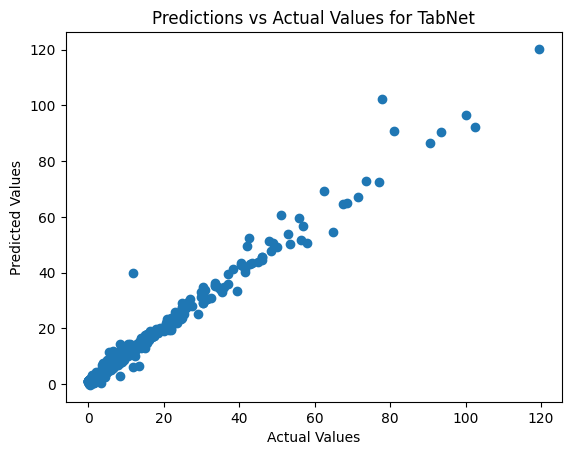

In [ ]:
#what we currently work on!!!!!
#import optuna
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('unified_players.csv')
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000
def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'TabNet':
        model = TabNetRegressor(**best_params)
        model.fit(X_train, y_train.reshape(-1, 1), max_epochs=500, patience=5, batch_size=1024)

    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
        'TabNet': {
            'n_d': 16,
            'n_a': 16,
            'n_steps': 3,
            'gamma': 1.2,
            'lambda_sparse': 1e-4
        }
    }


    # Training and evaluation
    for model_name in ['TabNet']:
    #for model_name in ['TabNet', 'MLP', 'XGBoost']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        model_name =train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params[model_name], target_scaler)
    return model_name
model_fifa=fifa_pred('value_eur_2022')


5_precent_accuracy for : 0.29241826381059755


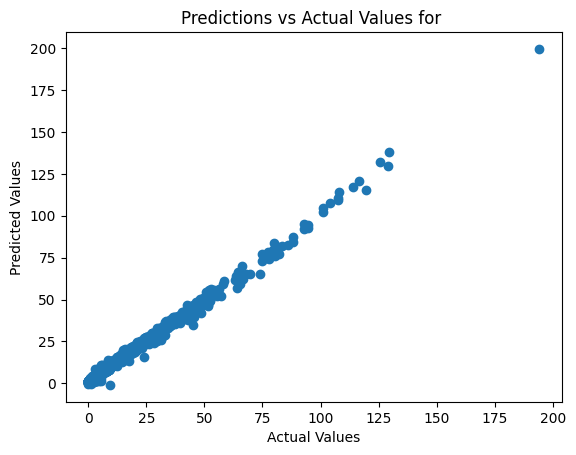

In [ ]:
# Predict and evaluate X_train_scaled, Y_train_scaled, it has 30% even on training
df = pd.read_csv('unified_players.csv')
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000
numeric_features = df.drop(columns=['value_eur_2022'])
target = df['value_eur_2022']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_train.values.reshape(-1, 1))

y_pred_scaled = model_fifa.predict(X_train_scaled)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

y_test_original = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
print(f'5_precent_accuracy for : {five_precent_accuracy}')

# Plot the predicted vs. actual values
plt.scatter(y_test_original, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Predictions vs Actual Values for ')
plt.show()
y_test_original = target_scaler.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()

In [ ]:
#log scalse- bad results ----------- ignore this:

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import torch.nn as nn

class CustomAccuracyLoss(nn.Module):
    def __init__(self, threshold=0.25):
        super(CustomAccuracyLoss, self).__init__()
        self.threshold = threshold

    def forward(self, y_true, y_pred):
        # Convert tensors to numpy arrays for custom accuracy calculation
        y_true_np = y_true.cpu().numpy().flatten()
        y_pred_np = y_pred.cpu().detach().numpy().flatten()
        y_pred_log = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_pred = np.expm1(y_pred_log)  # Reverse the log transformation
        y_test_original = target_scaler.inverse_transform(y_test.values.reshape(-1, 1))
        y_test = np.expm1(y_test_original)
        # Calculate percentage difference
        percentage_diff = np.abs((y_true_np - y_pred_np) / y_true_np)

        # Calculate custom accuracy
        accuracy = np.mean(percentage_diff <= self.threshold)

        # Loss is 1 - accuracy, since we want to maximize accuracy
        loss = 1 - accuracy
        return torch.tensor(loss, dtype=torch.float32)
class CustomTabNetRegressor(TabNetRegressor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.custom_loss = CustomAccuracyLoss(threshold=0.25)

    def fit(self, X_train, y_train, *args, **kwargs):
        # Use the standard fit method of TabNetRegressor
        super().fit(X_train, y_train, *args, **kwargs)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        loss_value = self.custom_loss(torch.tensor(y_test.values, dtype=torch.float32), torch.tensor(y_pred, dtype=torch.float32))
        return loss_value
def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.25)

    return accuracy

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, scaler, target_scaler):
    if model_name == 'TabNet':
        model = CustomTabNetRegressor(**best_params)
        model.max_epochs = 50  # Ensure this attribute is set
        model.fit(X_train, y_train.values.reshape(-1, 1), max_epochs=model.max_epochs, patience=5, batch_size=1024)

    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred_log = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_pred = np.expm1(y_pred_log)  # Reverse the log transformation

    y_test_original = target_scaler.inverse_transform(y_test.values.reshape(-1, 1))
    y_test = np.expm1(y_test_original)  # Reverse the log transformation
    #mae = mean_absolute_error(y_test, y_pred)
    #print(f"Mean Absolute Error for {model_name}: {mae}")
    #r2 = r2_score(y_test, y_pred)
    #print(f'R-squared for {model_name}: {r2}')
    five_precent_accuracy= custom_accuracy(y_test, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')
    #if 'mean_' in scaler.__dict__:
    #    y_pred_original = y_pred * target_scaler.scale_ + target_scaler.mean_
    #    y_test_original = y_test * target_scaler.scale_ + target_scaler.mean_
    #    five_precent_accuracy_original = custom_accuracy(y_test_original, y_pred_original)
    #    print(f'5_percent_accuracy_original for {model_name}: {five_precent_accuracy_original}')
    # Plot the predicted vs. actual values
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
def fifa_pred(target_column, tune_hyperparameters_flag=False):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    y_train_log = np.log1p(y_train.values)
    y_test_log = np.log1p(y_test.values)
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train_log.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test_log.reshape(-1, 1))

    # Default best parameters
    best_params = {
        'TabNet': {
            'n_d': 16,
            'n_a': 16,
            'n_steps': 3,
            'gamma': 1.2,
            'lambda_sparse': 1e-4
        },
        'MLP': {
            'hidden_layer_sizes': (100,),
            'alpha': 1e-3,
            'learning_rate_init': 1e-3
        },
        'XGBoost': {
            'n_estimators': 100,
            'max_depth': 3,
            'learning_rate': 0.1,
            'subsample': 0.8
        }
    }

    # Hyperparameter tuning (optional)
    if tune_hyperparameters_flag:
        for model_name in ['TabNet']:
        #for model_name in ['TabNet', 'MLP', 'XGBoost']:
            print(f"Tuning hyperparameters for {model_name}...")
            best_params[model_name] = tune_hyperparameters(X_train_scaled, X_test_scaled, y_train, y_test, model_name)

    # Training and evaluation
    for model_name in ['TabNet']:
    #for model_name in ['TabNet', 'MLP', 'XGBoost']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train, y_test, model_name, best_params[model_name], scaler, target_scaler)

# Run the prediction process with or without tuning
#fifa_pred('potential_2022', tune_hyperparameters_flag=False)
fifa_pred('value_eur_2022', tune_hyperparameters_flag=False)


ModuleNotFoundError: No module named 'pytorch_tabnet'

In [4]:
def fillna_avg_adjacent_rows(df):
    df_filled = df.copy()

    for col in df.columns:
        # Shift values up and down
        shifted_up = df[col].shift(1)
        shifted_down = df[col].shift(-1)

        # Compute the average of the row above and below
        avg_values = (shifted_up + shifted_down) / 2

        # Fill NaNs in the original DataFrame with computed averages
        df_filled[col] = df[col].fillna(avg_values)
        df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


    return df_filled


In [ ]:
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'  # Update this if the column name is different

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets
#df_2015 = pd.read_csv('players_15.csv')
#df_2016 = pd.read_csv('players_16.csv')
#df_2017 = pd.read_csv('players_17.csv')
#df_2018 = pd.read_csv('players_18.csv')
#df_2019 = pd.read_csv('players_19.csv')
df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]
#df = create_unified_dataset_with_colors([df_2015,df_2016,df_2017,df_2018,df_2019,df_2020, df_2021, df_2022], [2015,2016,2017,2018,2019,2020, 2021, 2022], use_columns)

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)

#print(f'Unified dataset created with {len(df)} records.')


<ipython-input-19-1fba4434493a>:64: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-18-aa6fd28816c9>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


In [ ]:
df = pd.read_csv('unified_players.csv')
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000


# List of key attributes to keep
key_attributes = [
    'overall', 'potential', 'pace', 'shooting', 'passing',
    'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'
]
test_attributes = [
    'overall', 'potential', 'value_eur', 'club_team_id'
]

# Create a list of columns to keep, including the years 2020, 2021, 2022
columns_to_keep = []
#for attr in test_attributes:
    #columns_to_keep.extend([f'{attr}_2020', f'{attr}_2021', f'{attr}_2022'])



# Drop all columns that are not in columns_to_keep
#df = df[columns_to_keep]
#df = df[df['value_eur_2022'] > 1]

# Save the reduced dataframe to a new CSV file (optional)
df.to_csv('df_reduced.csv', index=False)

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.1 MB/s eta 0:00:00


Training and evaluating catboost with best hyperparameters...
0:	learn: 0.9626690	test: 1.1061311	best: 1.1061311 (0)	total: 47.9ms	remaining: 5m 34s
100:	learn: 0.1516714	test: 0.2257944	best: 0.2257944 (100)	total: 4.22s	remaining: 4m 48s
200:	learn: 0.1029220	test: 0.2008029	best: 0.2007551 (199)	total: 7.12s	remaining: 4m
300:	learn: 0.0695720	test: 0.1868625	best: 0.1868625 (300)	total: 13.4s	remaining: 4m 57s
400:	learn: 0.0484343	test: 0.1817658	best: 0.1817658 (400)	total: 19.4s	remaining: 5m 18s
500:	learn: 0.0371439	test: 0.1800920	best: 0.1800920 (500)	total: 23.8s	remaining: 5m 9s
600:	learn: 0.0294355	test: 0.1793306	best: 0.1793281 (599)	total: 30.2s	remaining: 5m 21s
700:	learn: 0.0242490	test: 0.1787308	best: 0.1787206 (696)	total: 34.8s	remaining: 5m 12s
800:	learn: 0.0200455	test: 0.1783699	best: 0.1783699 (800)	total: 40.1s	remaining: 5m 10s
900:	learn: 0.0168766	test: 0.1781988	best: 0.1781988 (900)	total: 45.9s	remaining: 5m 10s
1000:	learn: 0.0146875	test: 0.17813

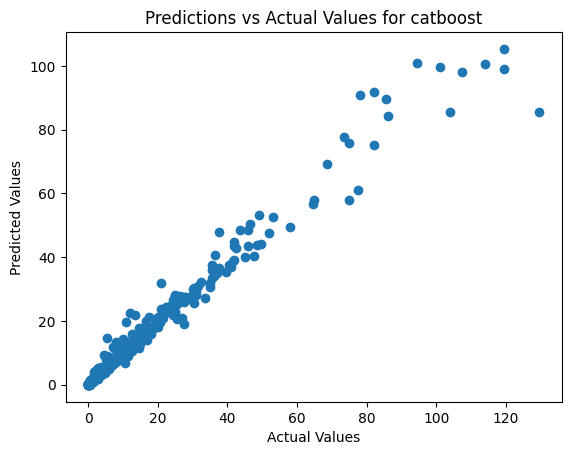

In [ ]:
#improve complexity good run- dont touch!!!!
#import optuna
#from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
#from pytorch_tabnet.pretraining import TabNetPretrainer
#from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch

def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is (1 - custom_accuracy).
    """
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    # Calculate the percentage difference
    percentage_diff = torch.abs((y_true - y_pred) / y_true)

    # Calculate accuracy (percentage difference within 10%)
    accuracy = torch.mean((percentage_diff <= 0.1).float())

    # Return the loss as 1 - accuracy (since accuracy is the metric we want to maximize)
    loss = 1 - accuracy

    return loss

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'TabNet_pretrain':
    #if model_name == 'TabNet
        pretrainer = TabNetPretrainer(**best_params)
        pretrainer.fit(X_train=X_train,eval_set=[X_test],max_epochs=500,patience=5,batch_size=32,pretraining_ratio=0.8)

    # Step 2: Load the pre-trained model and fine-tune
        model = TabNetRegressor(**best_params)
        model.fit(
        X_train=X_train, y_train=y_train.reshape(-1, 1),
        eval_set=[(X_test, y_test.reshape(-1, 1))],
        max_epochs=500,
        patience=5,
        batch_size=32,
        from_unsupervised=pretrainer,
        loss_fn=custom_loss
    )
    elif model_name == 'TabNet':
        model = TabNetRegressor(**best_params)
        model.fit(
            X_train, y_train.reshape(-1, 1),
            max_epochs=500,
            patience=5,
            batch_size=1024
            #loss_fn=custom_loss  # Use the custom loss function
        )
    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
    elif model_name == 'Stacked':
        # Create base models
        base_models = [
            ('mlp', Pipeline([
                ('scaler', StandardScaler()),
                ('mlp', MLPRegressor(**best_params['MLP'], max_iter=500, random_state=42))
            ])),
            ('xgb', XGBRegressor(**best_params['XGBoost'], random_state=42)),
            ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=42)),
            ('svr', SVR(**best_params['SVR']))
        ]
        # Define the meta-model
        meta_model = Ridge(alpha=1.0, random_state=42)

        # Create the Stacking Regressor
        model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
        model.fit(X_train, y_train)
    elif model_name == 'catboost':
        model = CatBoostRegressor(iterations=7000, depth=10, learning_rate=0.05)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)



    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
    'TabNet': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'catboost': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'Stacked': {
        'MLP': {
            'hidden_layer_sizes': (100, 100),
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001
        },
        'XGBoost': {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        },
        'RandomForest': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        },
        'SVR': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        }
    }
}



    # Training and evaluation
    for model_name in ['catboost']:
    #for model_name in ['TabNet', 'MLP', 'XGBoost', TabNet_pretrain]:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params[model_name], target_scaler)

fifa_pred('value_eur_2022')


In [ ]:
!pip install Optuna

In [31]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
numeric_features = df.drop(columns=['value_eur_2022'])
target = df['value_eur_2022']

    # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'iterations': trial.suggest_int('iterations', 4000, 5000),
        'depth': trial.suggest_int('depth', 10, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        #'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
        #'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        #'random_strength': trial.suggest_uniform('random_strength', 0, 1),
        #'border_count': trial.suggest_int('border_count', 32, 255),
        #'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 255)
    }

    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))

    # Make predictions and calculate the mean absolute error
    y_pred = model.predict(X_test)
    score = mean_absolute_error(y_test, y_pred)
    return score

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-08-14 19:25:55,632] A new study created in memory with name: no-name-7fcba251-b27f-4a20-b839-36522e0b661a
<ipython-input-31-1f13dae4550e>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2024-08-14 19:39:55,906] Trial 0 finished with value: 0.44452514963094114 and parameters: {'iterations': 4445, 'depth': 12, 'learning_rate': 0.015348849414642799}. Best is trial 0 with value: 0.44452514963094114.
<ipython-input-31-1f13dae4550e>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2024-08-14 19:46:58,003] Trial 1 finish

Best hyperparameters:  {'iterations': 4711, 'depth': 10, 'learning_rate': 0.011068343164856548}


<ipython-input-4-03fd995a8725>:66: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-3-d5cc0dd32cd6>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating catboost with best hyperparameters...
0:	learn: 0.9922873	test: 1.1413767	best: 1.1413767 (0)	total: 220ms	remaining: 25m 42s
100:	learn: 0.4775237	test: 0.5649086	best: 0.5649086 (100)	total: 20.5s	remaining: 23m 20s
200:	learn: 0.2600860	test: 0.3179906	best: 0.3179906 (200)	total: 38.9s	remaining: 21m 54s
300:	learn: 0.1712540	test: 0.2286102	best: 0.2286102 (300)	total: 57.2s	remaining: 21m 11s
400:	learn: 0.1319015	test: 0.1984773	best: 0.1984773 (400)	total: 1m 14s	remaining: 20m 30s
500:	learn: 0.1141892	test: 0.1863406	best: 0.1863406 (500)	total: 1m 27s	remaining: 18m 57s
600:	learn: 0.1014970	test: 0.1763372	best: 0.1763372 (600)	total: 1m 40s	remaining: 17m 50s
700:	learn: 0.0916065	test: 0.1686828	best: 0.1686828 (700)	total: 1m 54s	remaining: 17m 5s
800:	learn: 0.0837697	test: 0.1625802	best: 0.1625802 (800)	total: 2m 9s	remaining: 16m 39s
900:	learn: 0.0778710	test: 0.1579217	best: 0.1579194 (899)	total: 2m 27s	remaining: 16m 38s
1000:	learn: 0.072

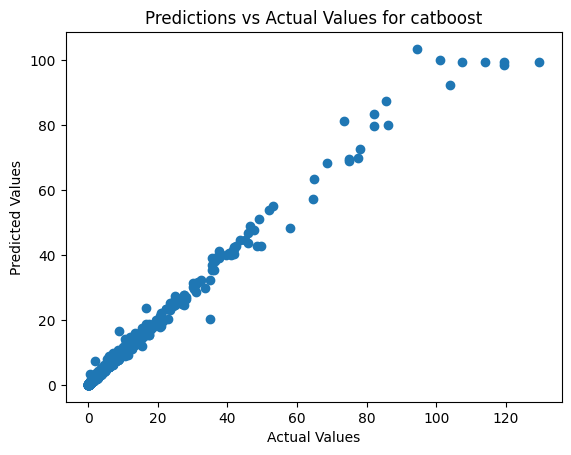

In [4]:
#try with better hyper-parameters
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'  # Update this if the column name is different

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        df_filtered = df
        #df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets
#df_2015 = pd.read_csv('players_15.csv')
#df_2016 = pd.read_csv('players_16.csv')
#df_2017 = pd.read_csv('players_17.csv')
#df_2018 = pd.read_csv('players_18.csv')
#df_2019 = pd.read_csv('players_19.csv')
df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]
#df = create_unified_dataset_with_colors([df_2015,df_2016,df_2017,df_2018,df_2019,df_2020, df_2021, df_2022], [2015,2016,2017,2018,2019,2020, 2021, 2022], use_columns)

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000
#print(f'Unified dataset created with {len(df)} records.')

#import optuna
#from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
#from pytorch_tabnet.pretraining import TabNetPretrainer
#from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch

def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is (1 - custom_accuracy).
    """
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    # Calculate the percentage difference
    percentage_diff = torch.abs((y_true - y_pred) / y_true)

    # Calculate accuracy (percentage difference within 10%)
    accuracy = torch.mean((percentage_diff <= 0.1).float())

    # Return the loss as 1 - accuracy (since accuracy is the metric we want to maximize)
    loss = 1 - accuracy

    return loss

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'TabNet_pretrain':
    #if model_name == 'TabNet
        pretrainer = TabNetPretrainer(**best_params)
        pretrainer.fit(X_train=X_train,eval_set=[X_test],max_epochs=500,patience=5,batch_size=32,pretraining_ratio=0.8)

    # Step 2: Load the pre-trained model and fine-tune
        model = TabNetRegressor(**best_params)
        model.fit(
        X_train=X_train, y_train=y_train.reshape(-1, 1),
        eval_set=[(X_test, y_test.reshape(-1, 1))],
        max_epochs=500,
        patience=5,
        batch_size=32,
        from_unsupervised=pretrainer,
        loss_fn=custom_loss
    )
    elif model_name == 'TabNet':
        model = TabNetRegressor(**best_params)
        model.fit(
            X_train, y_train.reshape(-1, 1),
            max_epochs=500,
            patience=5,
            batch_size=1024
            #loss_fn=custom_loss  # Use the custom loss function
        )
    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
    elif model_name == 'Stacked':
        # Create base models
        base_models = [
            ('mlp', Pipeline([
                ('scaler', StandardScaler()),
                ('mlp', MLPRegressor(**best_params['MLP'], max_iter=500, random_state=42))
            ])),
            ('xgb', XGBRegressor(**best_params['XGBoost'], random_state=42)),
            ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=42)),
            ('svr', SVR(**best_params['SVR']))
        ]
        # Define the meta-model
        meta_model = Ridge(alpha=1.0, random_state=42)

        # Create the Stacking Regressor
        model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
        model.fit(X_train, y_train)
    elif model_name == 'catboost':
        model = CatBoostRegressor(iterations=7000, depth=10, learning_rate=0.01)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)



    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
    'TabNet': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'catboost': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'Stacked': {
        'MLP': {
            'hidden_layer_sizes': (100, 100),
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001
        },
        'XGBoost': {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        },
        'RandomForest': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        },
        'SVR': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        }
    }
}



    # Training and evaluation
    for model_name in ['catboost']:
    #for model_name in ['TabNet', 'MLP', 'XGBoost', TabNet_pretrain]:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params[model_name], target_scaler)

fifa_pred('value_eur_2022')


<ipython-input-14-9af4622385ce>:66: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-3-d5cc0dd32cd6>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating catboost with best hyperparameters...
0:	learn: 0.9576006	test: 0.9643684	best: 0.9643684 (0)	total: 106ms	remaining: 12m 25s
100:	learn: 0.1733004	test: 0.1821063	best: 0.1821063 (100)	total: 6.76s	remaining: 7m 42s
200:	learn: 0.1393488	test: 0.1582263	best: 0.1582261 (199)	total: 13.2s	remaining: 7m 26s
300:	learn: 0.1188339	test: 0.1487616	best: 0.1487616 (300)	total: 17.9s	remaining: 6m 39s
400:	learn: 0.1051089	test: 0.1455899	best: 0.1455899 (400)	total: 23.3s	remaining: 6m 23s
500:	learn: 0.0929813	test: 0.1434223	best: 0.1434160 (499)	total: 29.2s	remaining: 6m 19s
600:	learn: 0.0834098	test: 0.1420408	best: 0.1420408 (600)	total: 33.9s	remaining: 6m 1s
700:	learn: 0.0747173	test: 0.1410799	best: 0.1410793 (698)	total: 40.4s	remaining: 6m 3s
800:	learn: 0.0672478	test: 0.1404127	best: 0.1404096 (797)	total: 44.9s	remaining: 5m 47s
900:	learn: 0.0608911	test: 0.1399602	best: 0.1399602 (900)	total: 49.5s	remaining: 5m 34s
1000:	learn: 0.0545527	test: 0.13

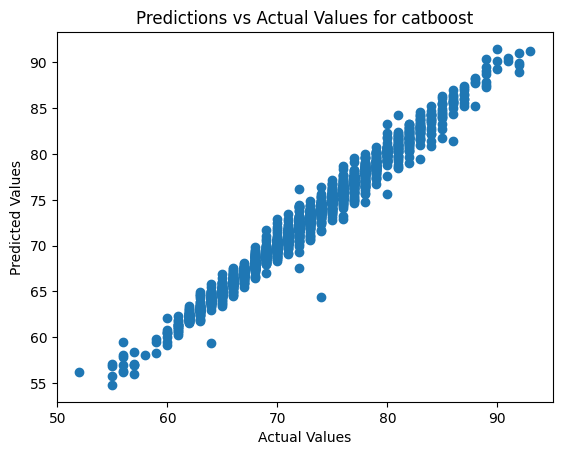

In [14]:
#try with better hyper-parameters
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'  # Update this if the column name is different

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets
#df_2015 = pd.read_csv('players_15.csv')
#df_2016 = pd.read_csv('players_16.csv')
#df_2017 = pd.read_csv('players_17.csv')
#df_2018 = pd.read_csv('players_18.csv')
#df_2019 = pd.read_csv('players_19.csv')
df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]
#df = create_unified_dataset_with_colors([df_2015,df_2016,df_2017,df_2018,df_2019,df_2020, df_2021, df_2022], [2015,2016,2017,2018,2019,2020, 2021, 2022], use_columns)

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000
#print(f'Unified dataset created with {len(df)} records.')

#import optuna
#from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
#from pytorch_tabnet.pretraining import TabNetPretrainer
#from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch

def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.02)

    return accuracy
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is (1 - custom_accuracy).
    """
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    # Calculate the percentage difference
    percentage_diff = torch.abs((y_true - y_pred) / y_true)

    # Calculate accuracy (percentage difference within 10%)
    accuracy = torch.mean((percentage_diff <= 0.02).float())

    # Return the loss as 1 - accuracy (since accuracy is the metric we want to maximize)
    loss = 1 - accuracy

    return loss

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'TabNet_pretrain':
    #if model_name == 'TabNet
        pretrainer = TabNetPretrainer(**best_params)
        pretrainer.fit(X_train=X_train,eval_set=[X_test],max_epochs=500,patience=5,batch_size=32,pretraining_ratio=0.8)

    # Step 2: Load the pre-trained model and fine-tune
        model = TabNetRegressor(**best_params)
        model.fit(
        X_train=X_train, y_train=y_train.reshape(-1, 1),
        eval_set=[(X_test, y_test.reshape(-1, 1))],
        max_epochs=500,
        patience=5,
        batch_size=32,
        from_unsupervised=pretrainer,
        loss_fn=custom_loss
    )
    elif model_name == 'TabNet':
        model = TabNetRegressor(**best_params)
        model.fit(
            X_train, y_train.reshape(-1, 1),
            max_epochs=3000,
            patience=5,
            batch_size=1024,
            loss_fn=custom_loss  # Use the custom loss function
        )
    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
    elif model_name == 'Stacked':
        # Create base models
        base_models = [
            ('mlp', Pipeline([
                ('scaler', StandardScaler()),
                ('mlp', MLPRegressor(**best_params['MLP'], max_iter=500, random_state=42))
            ])),
            ('xgb', XGBRegressor(**best_params['XGBoost'], random_state=42)),
            ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=42)),
            ('svr', SVR(**best_params['SVR']))
        ]
        # Define the meta-model
        meta_model = Ridge(alpha=1.0, random_state=42)

        # Create the Stacking Regressor
        model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
        model.fit(X_train, y_train)
    elif model_name == 'catboost':
        model = CatBoostRegressor(iterations=7000, depth=10, learning_rate=0.05)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)



    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
    'TabNet': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'catboost': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'Stacked': {
        'MLP': {
            'hidden_layer_sizes': (100, 100),
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001
        },
        'XGBoost': {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        },
        'RandomForest': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        },
        'SVR': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        }
    }
}



    # Training and evaluation
    for model_name in ['catboost']:
    #for model_name in ['TabNet', 'MLP', 'XGBoost', TabNet_pretrain]:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params[model_name], target_scaler)

fifa_pred('potential_2022')


<ipython-input-17-5a37e7b8365c>:66: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2022 = pd.read_csv('players_22.csv')
<ipython-input-3-d5cc0dd32cd6>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating TabNet with best hyperparameters...


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.99336 |  0:00:00s
epoch 1  | loss: 0.99662 |  0:00:01s
epoch 2  | loss: 0.99441 |  0:00:01s
epoch 3  | loss: 0.99343 |  0:00:02s
epoch 4  | loss: 0.99477 |  0:00:02s
epoch 5  | loss: 0.99574 |  0:00:03s
epoch 6  | loss: 0.99501 |  0:00:03s
epoch 7  | loss: 0.99525 |  0:00:04s
epoch 8  | loss: 0.9944  |  0:00:04s
epoch 9  | loss: 0.99378 |  0:00:05s
epoch 10 | loss: 0.99537 |  0:00:06s
epoch 11 | loss: 0.9933  |  0:00:06s
epoch 12 | loss: 0.99415 |  0:00:07s
epoch 13 | loss: 0.99451 |  0:00:08s
epoch 14 | loss: 0.99549 |  0:00:08s
epoch 15 | loss: 0.99549 |  0:00:09s
epoch 16 | loss: 0.99403 |  0:00:09s
epoch 17 | loss: 0.99402 |  0:00:10s
epoch 18 | loss: 0.99537 |  0:00:10s
epoch 19 | loss: 0.99451 |  0:00:11s
epoch 20 | loss: 0.99305 |  0:00:11s
epoch 21 | loss: 0.99256 |  0:00:11s
epoch 22 | loss: 0.99207 |  0:00:12s
epoch 23 | loss: 0.99256 |  0:00:12s
epoch 24 | loss: 0.99366 |  0:00:13s
epoch 25 | loss: 0.99475 |  0:00:13s
epoch 26 | loss: 0.99341 |  0:00:14s
e

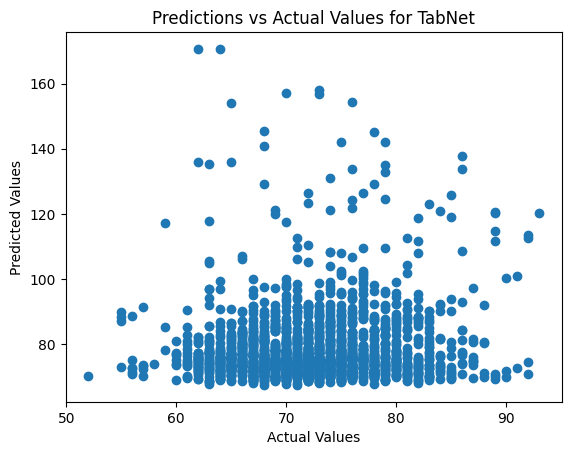

Training and evaluating Stacked with best hyperparameters...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_stacking.py:955: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5_precent_accuracy for Stacked: 0.9218825812712276


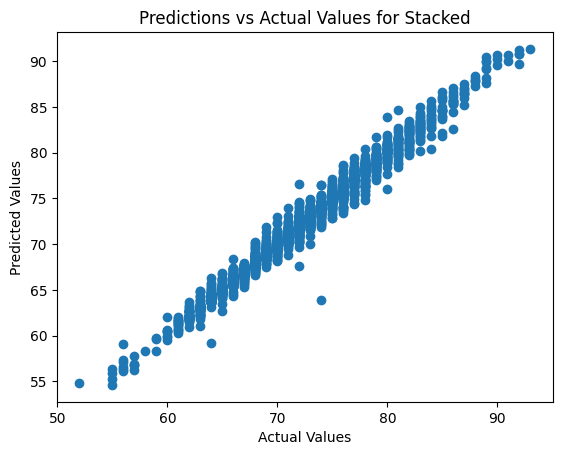

Training and evaluating catboost with best hyperparameters...
0:	learn: 0.9576006	test: 0.9643684	best: 0.9643684 (0)	total: 48.7ms	remaining: 5m 40s
100:	learn: 0.1733004	test: 0.1821063	best: 0.1821063 (100)	total: 4.62s	remaining: 5m 15s
200:	learn: 0.1393488	test: 0.1582263	best: 0.1582261 (199)	total: 9.51s	remaining: 5m 21s
300:	learn: 0.1188339	test: 0.1487616	best: 0.1487616 (300)	total: 15.4s	remaining: 5m 43s
400:	learn: 0.1051089	test: 0.1455899	best: 0.1455899 (400)	total: 20s	remaining: 5m 28s
500:	learn: 0.0929813	test: 0.1434223	best: 0.1434160 (499)	total: 26.2s	remaining: 5m 40s
600:	learn: 0.0834098	test: 0.1420408	best: 0.1420408 (600)	total: 30.8s	remaining: 5m 28s
700:	learn: 0.0747173	test: 0.1410799	best: 0.1410793 (698)	total: 35.3s	remaining: 5m 17s
800:	learn: 0.0672478	test: 0.1404127	best: 0.1404096 (797)	total: 41.7s	remaining: 5m 22s
900:	learn: 0.0608911	test: 0.1399602	best: 0.1399602 (900)	total: 46.2s	remaining: 5m 12s
1000:	learn: 0.0545527	test: 0.13

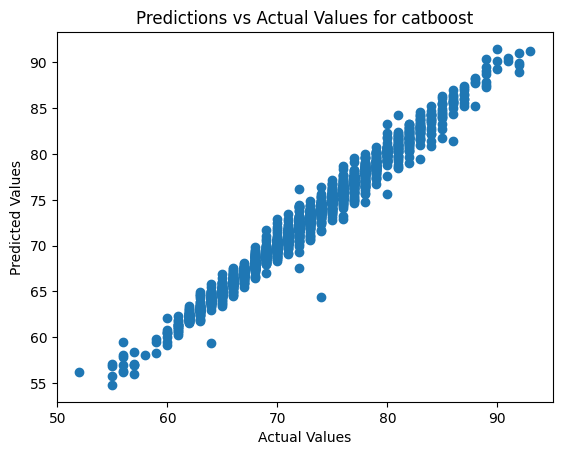

In [17]:
#try with better hyper-parameters
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'  # Update this if the column name is different

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        #df_filtered = df
        df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets
#df_2015 = pd.read_csv('players_15.csv')
#df_2016 = pd.read_csv('players_16.csv')
#df_2017 = pd.read_csv('players_17.csv')
#df_2018 = pd.read_csv('players_18.csv')
#df_2019 = pd.read_csv('players_19.csv')
df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]
#df = create_unified_dataset_with_colors([df_2015,df_2016,df_2017,df_2018,df_2019,df_2020, df_2021, df_2022], [2015,2016,2017,2018,2019,2020, 2021, 2022], use_columns)

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000
#print(f'Unified dataset created with {len(df)} records.')

#import optuna
#from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
#from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch

def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.02)

    return accuracy
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is (1 - custom_accuracy).
    """
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    # Calculate the percentage difference
    percentage_diff = torch.abs((y_true - y_pred) / y_true)

    # Calculate accuracy (percentage difference within 10%)
    accuracy = torch.mean((percentage_diff <= 0.02).float())

    # Return the loss as 1 - accuracy (since accuracy is the metric we want to maximize)
    loss = 1 - accuracy

    return loss

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'TabNet_pretrain':
    #if model_name == 'TabNet
        pretrainer = TabNetPretrainer(**best_params)
        pretrainer.fit(X_train=X_train,eval_set=[X_test],max_epochs=500,patience=5,batch_size=32,pretraining_ratio=0.8)

    # Step 2: Load the pre-trained model and fine-tune
        model = TabNetRegressor(**best_params)
        model.fit(
        X_train=X_train, y_train=y_train.reshape(-1, 1),
        eval_set=[(X_test, y_test.reshape(-1, 1))],
        max_epochs=500,
        patience=5,
        batch_size=32,
        from_unsupervised=pretrainer,
        loss_fn=custom_loss
    )
    elif model_name == 'TabNet':
        model = TabNetRegressor(**best_params)
        model.fit(
            X_train, y_train.reshape(-1, 1),
            max_epochs=300,
            patience=5,
            batch_size=1024,
            loss_fn=custom_loss  # Use the custom loss function
        )
    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
    elif model_name == 'Stacked':
        # Create base models
        base_models = [
            ('mlp', Pipeline([
                ('scaler', StandardScaler()),
                ('mlp', MLPRegressor(**best_params['MLP'], max_iter=500, random_state=42))
            ])),
            ('xgb', XGBRegressor(**best_params['XGBoost'], random_state=42)),
            ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=42)),
            ('svr', SVR(**best_params['SVR']))
        ]
        # Define the meta-model
        meta_model = Ridge(alpha=1.0, random_state=42)

        # Create the Stacking Regressor
        model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
        model.fit(X_train, y_train)
    elif model_name == 'catboost':
        model = CatBoostRegressor(iterations=7000, depth=10, learning_rate=0.05)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)



    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
    'TabNet': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'catboost': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'Stacked': {
        'MLP': {
            'hidden_layer_sizes': (100, 100),
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001
        },
        'XGBoost': {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        },
        'RandomForest': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        },
        'SVR': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        }
    }
}



    # Training and evaluation
    #for model_name in ['catboost']:
    for model_name in ['TabNet', 'Stacked', 'catboost']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params[model_name], target_scaler)

fifa_pred('potential_2022')


<ipython-input-4-d5cc0dd32cd6>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')


Training and evaluating TabNet with best hyperparameters...


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.95569 |  0:00:00s
epoch 1  | loss: 0.95641 |  0:00:01s
epoch 2  | loss: 0.96128 |  0:00:01s
epoch 3  | loss: 0.96737 |  0:00:02s
epoch 4  | loss: 0.95856 |  0:00:02s
epoch 5  | loss: 0.96367 |  0:00:03s
epoch 6  | loss: 0.95927 |  0:00:03s
epoch 7  | loss: 0.96463 |  0:00:04s
epoch 8  | loss: 0.96609 |  0:00:04s
epoch 9  | loss: 0.96999 |  0:00:05s
epoch 10 | loss: 0.96315 |  0:00:06s
epoch 11 | loss: 0.96193 |  0:00:06s
epoch 12 | loss: 0.96803 |  0:00:07s
epoch 13 | loss: 0.96901 |  0:00:08s
epoch 14 | loss: 0.96827 |  0:00:08s
epoch 15 | loss: 0.97023 |  0:00:09s
epoch 16 | loss: 0.97047 |  0:00:10s
epoch 17 | loss: 0.97169 |  0:00:11s
epoch 18 | loss: 0.9712  |  0:00:11s
epoch 19 | loss: 0.97486 |  0:00:12s
epoch 20 | loss: 0.96754 |  0:00:13s
epoch 21 | loss: 0.97242 |  0:00:13s
epoch 22 | loss: 0.97095 |  0:00:14s
epoch 23 | loss: 0.9734  |  0:00:14s
epoch 24 | loss: 0.97193 |  0:00:15s
epoch 25 | loss: 0.9734  |  0:00:15s
epoch 26 | loss: 0.96802 |  0:00:16s
e

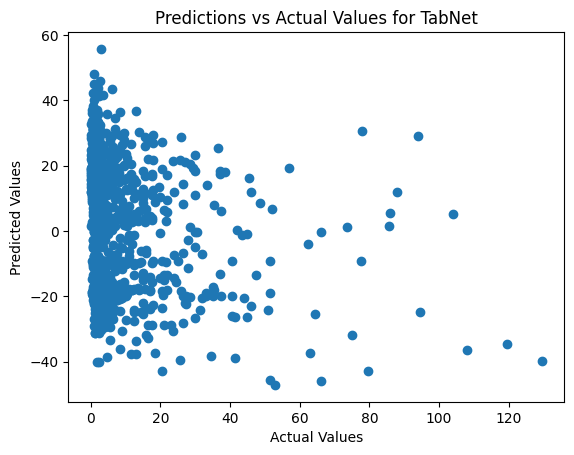

Training and evaluating Stacked with best hyperparameters...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_stacking.py:955: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


5_precent_accuracy for Stacked: 0.653635652853792


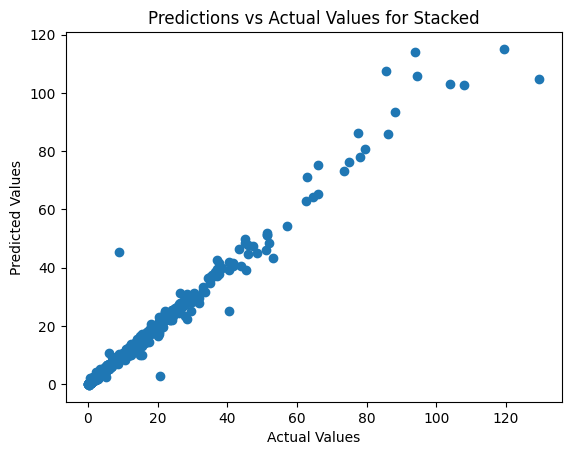

Training and evaluating catboost with best hyperparameters...
0:	learn: 0.9929810	test: 1.1117354	best: 1.1117354 (0)	total: 255ms	remaining: 29m 44s
100:	learn: 0.4916004	test: 0.5524453	best: 0.5524453 (100)	total: 19.5s	remaining: 22m 14s
200:	learn: 0.2692332	test: 0.3117011	best: 0.3117011 (200)	total: 36.5s	remaining: 20m 35s
300:	learn: 0.1752020	test: 0.2249547	best: 0.2249547 (300)	total: 55.6s	remaining: 20m 37s
400:	learn: 0.1309759	test: 0.1963262	best: 0.1963262 (400)	total: 1m 13s	remaining: 20m 10s
500:	learn: 0.1085795	test: 0.1827326	best: 0.1827326 (500)	total: 1m 27s	remaining: 18m 53s
600:	learn: 0.0960990	test: 0.1761483	best: 0.1761483 (600)	total: 1m 40s	remaining: 17m 46s
700:	learn: 0.0866263	test: 0.1711886	best: 0.1711886 (700)	total: 1m 53s	remaining: 16m 58s
800:	learn: 0.0791777	test: 0.1668605	best: 0.1668605 (800)	total: 2m 7s	remaining: 16m 24s
900:	learn: 0.0722341	test: 0.1628512	best: 0.1628512 (900)	total: 2m 21s	remaining: 15m 54s
1000:	learn: 0.06

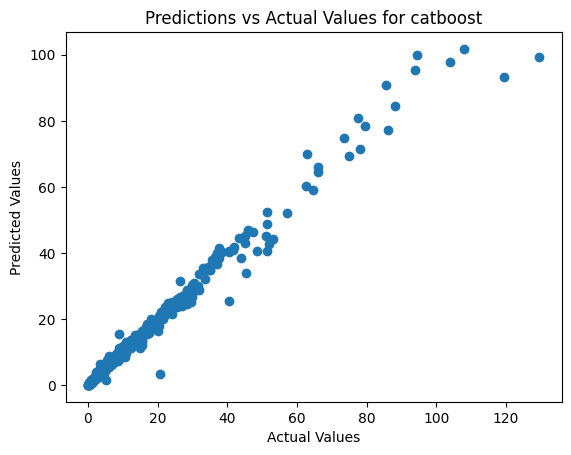

In [5]:
#try with better hyper-parameters
import pandas as pd

def create_unified_dataset_with_colors(dfs, years, use_columns):
    """
    Creates a unified dataset by merging multiple datasets and including only players with data in all datasets.
    Additionally, appends colors from each dataset and renames features to include the dataset year.

    Parameters:
    - dfs: List of DataFrames (one for each year, e.g., [df_2020, df_2021, df_2022])
    - years: List of years corresponding to each DataFrame (e.g., [2020, 2021, 2022])
    - use_columns: List of columns to keep for each year

    Returns:
    - unified_df: DataFrame with unified data including only players present in all datasets
    """

    # Identify the player name column
    player_col = 'long_name'  # Update this if the column name is different

    # Extract unique player names from each DataFrame
    player_sets = [set(df[player_col].unique()) for df in dfs]

    # Find common players present in all datasets
    common_players = set.intersection(*player_sets)

    # Filter and prepare each DataFrame
    filtered_dfs = []
    for i, (df, year) in enumerate(zip(dfs, years)):
        # Keep only the specified columns plus the player name column
        columns_to_use = use_columns[i] + [player_col]
        df_filtered = df
        #df_filtered = df[columns_to_use].copy()

        # Filter rows for common players
        df_filtered = df_filtered[df_filtered[player_col].isin(common_players)].copy()

        # Rename columns to include dataset year
        df_filtered = df_filtered.rename(columns=lambda x: f"{x}_{year}" if x != player_col else x)

        filtered_dfs.append(df_filtered)

    # Merge DataFrames on 'long_name'
    unified_df = pd.merge(filtered_dfs[0], filtered_dfs[1], on=player_col, how='inner')
    for df in filtered_dfs[2:]:
        unified_df = pd.merge(unified_df, df, on=player_col, how='inner')

    # Select only numeric features
    unified_df = unified_df.select_dtypes(include=['number'])

    # Drop rows with missing values
    unified_df = fillna_avg_adjacent_rows(unified_df)
    #unified_df = unified_df.apply(lambda col: col.fillna(col.mean()), axis=0)

    return unified_df


# Load the datasets
#df_2015 = pd.read_csv('players_15.csv')
#df_2016 = pd.read_csv('players_16.csv')
#df_2017 = pd.read_csv('players_17.csv')
#df_2018 = pd.read_csv('players_18.csv')
#df_2019 = pd.read_csv('players_19.csv')
df_2020 = pd.read_csv('players_20.csv')
df_2021 = pd.read_csv('players_21.csv')
df_2022 = pd.read_csv('players_22.csv')

# Create a unified dataset using specific columns
use_columns = [
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    #['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing'],
    ['overall', 'potential', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'value_eur', 'club_team_id','attacking_finishing']
]
#df = create_unified_dataset_with_colors([df_2015,df_2016,df_2017,df_2018,df_2019,df_2020, df_2021, df_2022], [2015,2016,2017,2018,2019,2020, 2021, 2022], use_columns)

df = create_unified_dataset_with_colors([df_2020, df_2021, df_2022], [2020, 2021, 2022], use_columns)

# Optionally, save the unified dataset to a CSV file
df.to_csv('unified_players.csv', index=False)
df['value_eur_2020'] = df['value_eur_2020']/1000000
df['value_eur_2021'] = df['value_eur_2021']/1000000
df['value_eur_2022'] = df['value_eur_2022']/1000000
#print(f'Unified dataset created with {len(df)} records.')

#import optuna
#from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
#from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from catboost import CatBoostRegressor
import torch

def custom_accuracy(y_true, y_pred):
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    # Calculate the percentage difference
    percentage_diff = np.abs((y_true - y_pred) / y_true)

    # Check if the percentage difference is within 5%
    accuracy = np.mean(percentage_diff <= 0.1)

    return accuracy
def custom_loss(y_true, y_pred):
    """
    Custom loss function based on the percentage difference.
    Returns the error to be minimized, which is (1 - custom_accuracy).
    """
    # Flatten the arrays to ensure they are 1-dimensional
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    # Calculate the percentage difference
    percentage_diff = torch.abs((y_true - y_pred) / y_true)

    # Calculate accuracy (percentage difference within 10%)
    accuracy = torch.mean((percentage_diff <= 0.1).float())

    # Return the loss as 1 - accuracy (since accuracy is the metric we want to maximize)
    loss = 1 - accuracy

    return loss

def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, best_params, target_scaler):
    if model_name == 'TabNet_pretrain':
    #if model_name == 'TabNet
        pretrainer = TabNetPretrainer(**best_params)
        pretrainer.fit(X_train=X_train,eval_set=[X_test],max_epochs=500,patience=5,batch_size=32,pretraining_ratio=0.8)

    # Step 2: Load the pre-trained model and fine-tune
        model = TabNetRegressor(**best_params)
        model.fit(
        X_train=X_train, y_train=y_train.reshape(-1, 1),
        eval_set=[(X_test, y_test.reshape(-1, 1))],
        max_epochs=500,
        patience=5,
        batch_size=32,
        from_unsupervised=pretrainer,
        loss_fn=custom_loss
    )
    elif model_name == 'TabNet':
        model = TabNetRegressor(**best_params)
        model.fit(
            X_train, y_train.reshape(-1, 1),
            max_epochs=300,
            patience=5,
            batch_size=1024,
            loss_fn=custom_loss  # Use the custom loss function
        )
    elif model_name == 'MLP':
        model = MLPRegressor(**best_params, max_iter=300, random_state=42)
        model.fit(X_train, y_train)

    elif model_name == 'XGBoost':
        model = XGBRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
    elif model_name == 'Stacked':
        # Create base models
        base_models = [
            ('mlp', Pipeline([
                ('scaler', StandardScaler()),
                ('mlp', MLPRegressor(**best_params['MLP'], max_iter=500, random_state=42))
            ])),
            ('xgb', XGBRegressor(**best_params['XGBoost'], random_state=42)),
            ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=42)),
            ('svr', SVR(**best_params['SVR']))
        ]
        # Define the meta-model
        meta_model = Ridge(alpha=1.0, random_state=42)

        # Create the Stacking Regressor
        model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
        model.fit(X_train, y_train)
    elif model_name == 'catboost':
        model = CatBoostRegressor(iterations=7000, depth=10, learning_rate=0.01)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)



    # Predict and evaluate
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    five_precent_accuracy= custom_accuracy(y_test_original, y_pred)
    print(f'5_precent_accuracy for {model_name}: {five_precent_accuracy}')

    # Plot the predicted vs. actual values
    plt.scatter(y_test_original, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs Actual Values for {model_name}')
    plt.show()
    return model

def fifa_pred(target_column):
    # Select only numeric features and drop irrelevant ones
    numeric_features = df.drop(columns=[target_column])
    target = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(numeric_features, target, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Scale the target variable
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

    # Default best parameters
    best_params = {
    'TabNet': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'catboost': {
        'n_d': 16,
        'n_a': 16,
        'n_steps': 3,
        'gamma': 1.2,
        'lambda_sparse': 1e-4
    },
    'Stacked': {
        'MLP': {
            'hidden_layer_sizes': (100, 100),
            'activation': 'relu',
            'solver': 'adam',
            'learning_rate': 'adaptive',
            'learning_rate_init': 0.001
        },
        'XGBoost': {
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.8
        },
        'RandomForest': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        },
        'SVR': {
            'kernel': 'rbf',
            'C': 1.0,
            'epsilon': 0.1
        }
    }
}



    # Training and evaluation
    #for model_name in ['catboost']:
    for model_name in ['TabNet', 'Stacked', 'catboost']:
        print(f"Training and evaluating {model_name} with best hyperparameters...")
        train_and_evaluate(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, model_name, best_params[model_name], target_scaler)

fifa_pred('value_eur_2022')
